# 3D Quasidynamic earthquake cycle modelling. First steps: a square fault in a full space.

I've been working to get functioning 3D quasidynamic earthquake cycle simulation set up for the last month. It's been an interesting puzzle working through some of the bugs and misunderstandings that have cropped up and I just figured I'd share the story.

During this process, I've read through a lot of the literature on quasidynamic rupture modeling. I've also read a bit about fully dynamic modeling, because it has many of the same complexities when simulating through multiple earthquake cycles! But, the two main sources that I returned to again and again are:

* Lapusta and Liu, *Three-dimensional boundary integral modeling of spontaneous earthquake sequences and aseismic slip*, 2009.
* Erickson and Dunham, *An efficient numerical method for earthquake cycles in heterogeneous media: Alternating sub-basin and surface-rupturing events on faults crossing a sedimentary basin*, 2014.

The Lapusta and Liu paper goes into substantial and directly useful detail on their implementation. As a complement, the Erickson and Dunham paper is nice because it's focused on a finite difference formulation that is in the time and space domain rather than the Fourier domain setting of the Lapusta and Liu paper. My boundary element method (BEM) implementation is also a time and space domain implementation. 

For an intro to the type of problems I'm solving here, checking out [my post on doing a similar 1D "spring-block-slider" model](http://tbenthompson.com/post/block_slider/). The difference is that, here, I'm modeling a fault surface in 3D domain, rather than a point contact in a 1D domain. That adds a lot more complexity to the implementation and . Primarily, doing this in 3D requires an "elastic solver", that will take the current total slip on the fault surface, any other non-fault boundary conditions, and return the traction on the fault surface. As I mentioned in the 1D post, at a high level, the problem is a simple feedback where I loop:

```
while not done:
    slip += velocity * dt
    traction = elastic_solver(slip)
    velocity = rate_state_solver(traction)
```

However, instead of the simple forward Euler method, I'm using a Runge-Kutta (4,5) method to automatically use the largest accurate time step.

# Slip vs Slip-deficit

This is a critical distinction. When calculating the traction on the fault surface, what we care about is the relative motion of the fault with respect to its surroundings. 

# Failure to impose continuity between adjacent elements.

If there is a discontinuity in slip between two adjacent elements, a stress singularity arises at the boundary between those elements. Infinite stress then passes through the friction law, and fundamentally, results in infinite slip. That's no good. So, imposing slip continuity is essential to having reasonable behavior. And it makes fundamental physical sense too. It's unlikely that large voids are forming deep in the Earth.

This is not a problem for most other quasidynamic earthquake modeling software. If you are using the Fourier domain formulation, you get slip continuity for free by virtue of each Fourier component being continuous in space and thus the sum of those components also being continuous. On the other hand, most Okada-dislocation based approaches (e.g. [QDyn](https://github.com/ydluo/qdyn)) evaluate the stress at the centers of elements. Thus, although the model has stress singularities, the stress is never evaluated in a singular region and the problem is partially avoided. On the other hand, I'm curious how the existence of those singularities affects the final results. In general, I believe the linear (or higher order) slip interpolation that I am using on element is better for this set of problems because it allows continuity.

# Inability to trigger ruptures. 

If I initialize the model with zero slip and a initial steady state parameter, and have $a-b < 0$ everywhere, I initially expected that the model would produce ruptures. Surprisingly, that did not happen. The slip rate evolved 



In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import tectosaur.mesh.mesh_gen

from scipy.integrate import RK45
from scipy.optimize import fsolve
from qd_helpers import *

Define the material, frictional, mesh and boundary condition parameters.

The parameters in `tectosaur_cfg` determine how the integration and evaluating of the integral equations are done. I'll get into the details of Tectosaur some time in the future. For the moment, just trust that Tectosaur does actually solve linear elastic boundary value problems. It's been around the block and has been tested thoroughly, especially for the type of dislocation problems I'm solving here.

In [2]:
n_fault = 200
W = 15000
w = 3000
fL = W + w
fW = W + w
m = tectosaur.mesh.mesh_gen.make_rect(n_fault * 2, n_fault, [
    [-fL, 0, w], [-fL, 0, -fW],
    [fL, 0, -fW], [fL, 0, w]
])
qdm = QDMeshData(m)

qd_cfg = dict(
    # Material properties
    sm = 3e10,          # Shear modulus (Pa)
    pr = 0.25,          # Poisson ratio 
    density = 2700,     # rock density (kg/m^3)

    # Frictional properties
    Dc = 0.01,         # state evolution length scale (m)
    f0 = 0.6,           # baseline coefficient of friction
    V0 = 1e-6,          # when V = V0, f = f0, V is (m/s)

    # Boundary conditions
    plate_rate = 1e-9,  # (m/s), equivalent to ~31.5 mm/yr
    
    # This is only necessary because this is a full space model and there's no concept of depth or gravity
    additional_normal_stress = 120e6, 
    
    tectosaur_cfg = dict(
        quad_mass_order = 4,       
        quad_vertadj_order = 8,
        quad_far_order = 3,
        quad_near_order = 5,
        quad_near_threshold = 2.5,
        float_type = np.float32,
        use_fmm = True,
        fmm_order = 150,
        fmm_mac = 3.0,
        pts_per_cell = 450,
        log_level = logging.INFO
    )
)
qd_cfg['cs'] = np.sqrt(qd_cfg['sm'] / qd_cfg['density'])# Shear wave speed (m/s)
qd_cfg['eta'] = qd_cfg['sm'] / (2 * qd_cfg['cs'])       # The radiation damping coefficient (kg / (m^2 * s))

/home/tthompson/tools/pyenv/versions/miniconda3-4.3.11/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


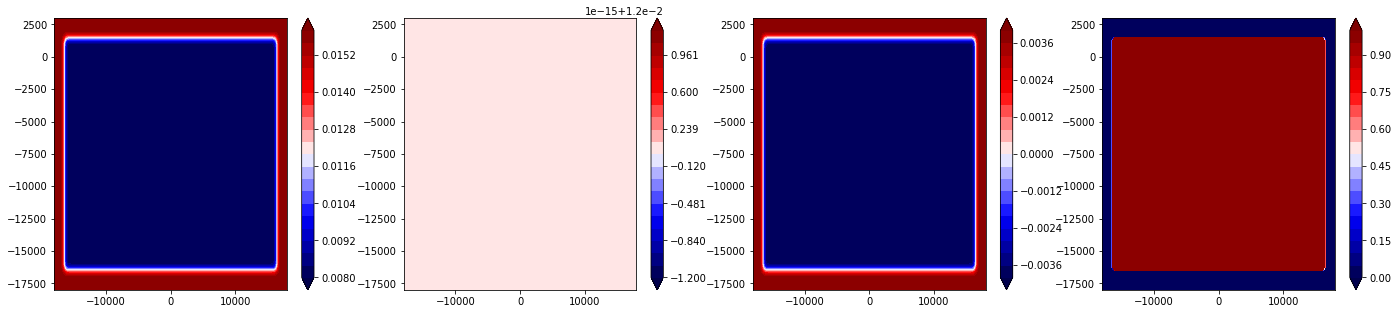

In [3]:
dof_pts = m[0][m[1]].reshape((-1,3))

# x_lims = np.logical_and(dof_pts[:,0] < 15000, dof_pts[:,0] > -15000)
# y_lims = np.logical_and(dof_pts[:,1] < 7500, dof_pts[:,1] > -7500)
# interior = np.logical_and(x_lims, y_lims)

def B(x, W, w):
    out = 0.5 * (1 + np.tanh((w / (np.abs(x) - W - w)) + (w / (np.abs(x) - W))))
    out[np.abs(x) <= W] = 1.0
    out[np.abs(x) >= W + w] = 0.0
    return out

delta_a0 = 0.008
y0 = -W / 2.0
delta_a = delta_a0 * (1 - B(dof_pts[:,0], W, w) * B(dof_pts[:,2] - y0, W / 2.0, w))
a = 0.008 + delta_a
b = np.ones_like(a) * 0.012
qd_cfg['a'] = a
qd_cfg['b'] = b
plot_fields(qdm.m, np.vstack((qd_cfg['a'], qd_cfg['b'], qd_cfg['a'] - qd_cfg['b'], qd_cfg['a'] - qd_cfg['b'] < 0)).T)

Check that the "process zone" and $k_{crit}$ are good. See section 6 in Erickson et al 2014

In [4]:
mesh_L = np.max(np.sqrt(np.linalg.norm(qdm.unscaled_tri_normals, axis = 1)))
Lb = qd_cfg['sm'] * qd_cfg['Dc'] / (qd_cfg['additional_normal_stress'] * qd_cfg['b'])
hstar = (np.pi * qd_cfg['sm'] * qd_cfg['Dc']) / (qd_cfg['additional_normal_stress'] * (qd_cfg['b'] - qd_cfg['a']))

hstarRA = (2.0 / np.pi) * qd_cfg['sm'] * qd_cfg['b'] * qd_cfg['Dc'] / ((qd_cfg['b'] - qd_cfg['a']) ** 2 * qd_cfg['additional_normal_stress'])
hstarRA3D = np.pi ** 2 / 4.0 * hstarRA
# all_fields = np.vstack((Lb, hstar, np.ones_like(hstar) * mesh_L)).T
# plot_fields(qdm.m, all_fields)
print('hstar (2d antiplane, erickson and dunham 2014)', np.min(np.abs(hstar)))
print('hstar_RA (2d antiplane, rubin and ampuero 2005)', np.min(np.abs(hstarRA)))
print('hstar_RA3D (3d strike slip, lapusta and liu 2009)', np.min(np.abs(hstarRA3D)))
print('cohesive zone length scale', np.min(Lb))
print('mesh length scale', mesh_L)

hstar (2d antiplane, erickson and dunham 2014) 1963.49540849
hstar_RA (2d antiplane, rubin and ampuero 2005) 1193.66207319
hstar_RA3D (3d strike slip, lapusta and liu 2009) 2945.24311274
cohesive zone length scale 208.333333333
mesh length scale 97.5771011244


In [5]:
sigma_n = qd_cfg['additional_normal_stress']
tau_inf = sigma_n * qd_cfg['a'] * np.arcsinh(
    qd_cfg['plate_rate'] / (2 * qd_cfg['V0']) * np.exp(qd_cfg['f0'] / qd_cfg['a'])
)
# state_inf = qd_cfg['a'] * np.log(
#     (2 * qd_cfg['V0'] / qd_cfg['plate_rate']) * np.sinh(
#         (tau_inf - qd_cfg['eta'] * qd_cfg['plate_rate']) / (qd_cfg['additional_normal_stress'] * qd_cfg['a'])
#     )
# )

In [6]:
traction_to_slip = get_traction_to_slip(qdm, qd_cfg)
slip_to_traction = get_slip_to_traction(qdm, qd_cfg)

[29084:INFO:tectosaur.util.cuda]
    Initialized CUDA on gpu: 0


In [7]:
derivs = make_qd_derivs(qdm, qd_cfg, slip_to_traction)

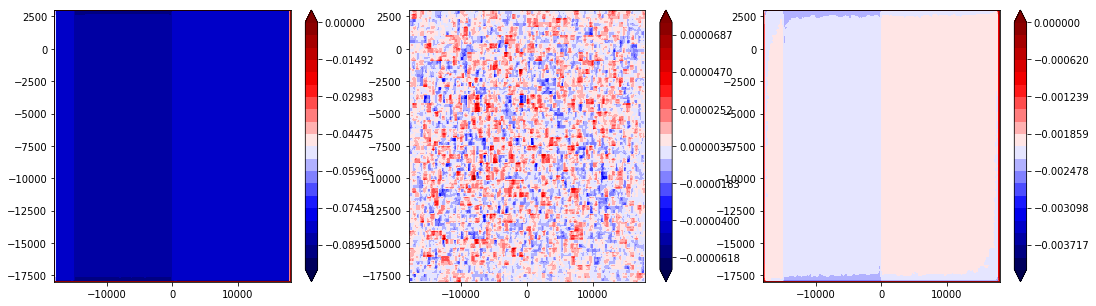

In [8]:
initial_stress = -qdm.field_100_interior * qd_cfg['f0'] * sigma_n
initial_stress.reshape((-1,3))[np.logical_and(dof_pts[:,0] > -15000, dof_pts[:,0] < -0), 0] *= 1.1
#initial_stress = qdm.field_100_interior
initial_slip = traction_to_slip(initial_stress)
plot_fields(qdm.m, initial_slip)

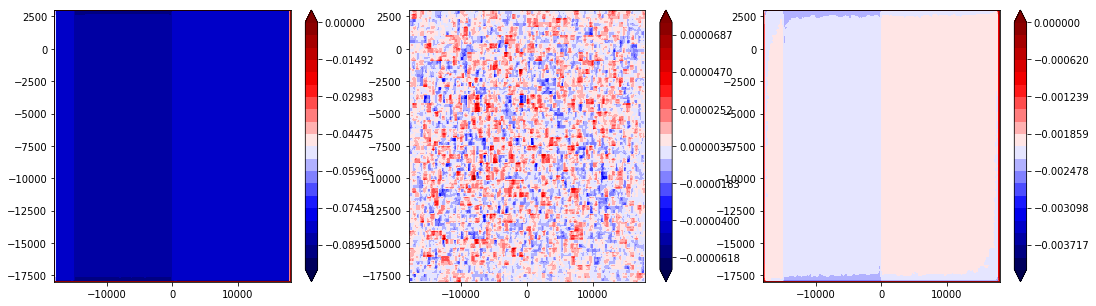

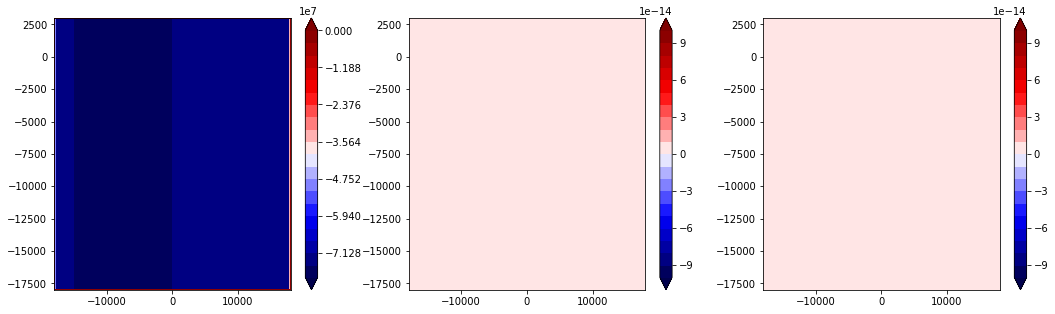

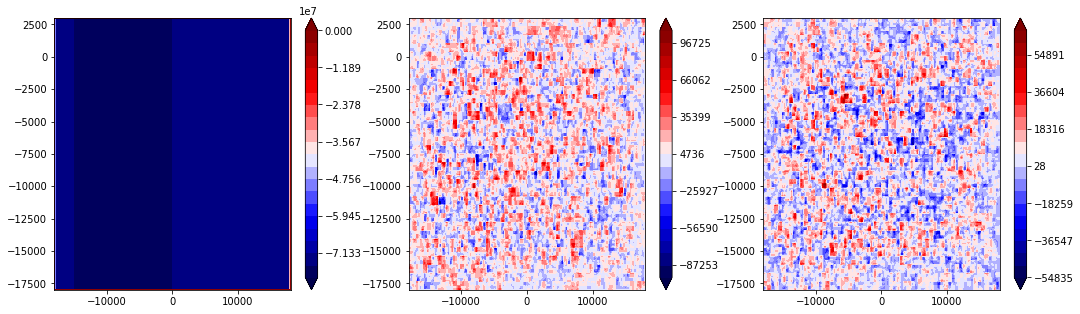

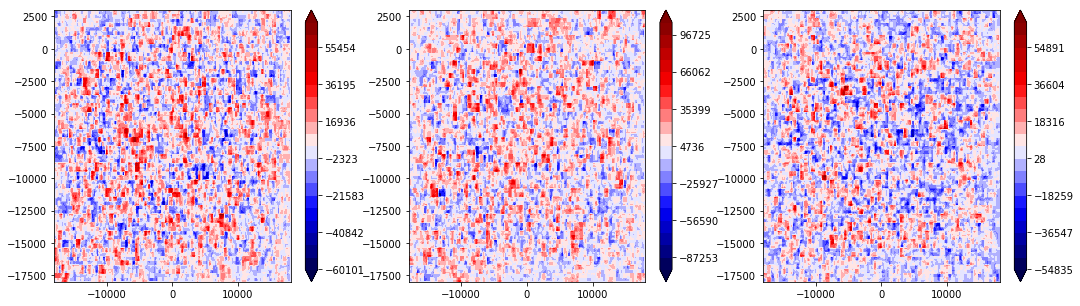

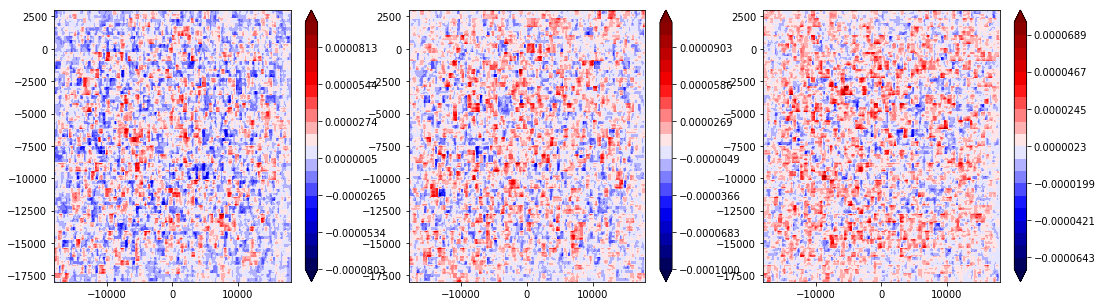

In [9]:
reverse = slip_to_traction(initial_slip)
plot_fields(qdm.m, initial_slip)
plot_fields(qdm.m, initial_stress)
plot_fields(qdm.m, reverse)
plot_fields(qdm.m, reverse - initial_stress)
NS = traction_to_slip((reverse - initial_stress))
plot_fields(qdm.m, NS)

In [10]:
# A = slip_to_traction(initial_slip + NS)
# B = slip_to_traction(initial_slip)
# C = slip_to_traction(NS)
# plot_fields(qdm.m, A)
# plot_fields(qdm.m, B)
# plot_fields(qdm.m, C)

In [11]:
initial_stress_mag = np.linalg.norm(initial_stress.reshape((-1,3)), axis = 1)

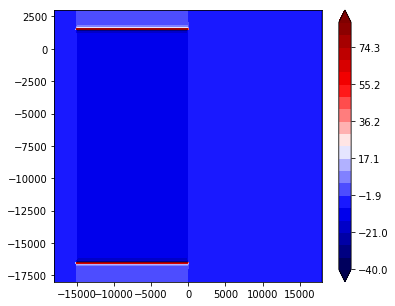

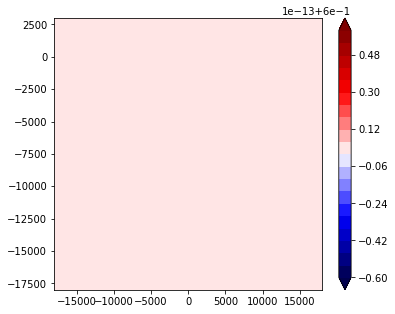

In [12]:
initial_vel = qd_cfg['V0'] * np.exp((1 / (qd_cfg['a'] - qd_cfg['b'])) * (initial_stress_mag / sigma_n - qd_cfg['f0']))
initial_state = np.ones_like(initial_vel) * 0.6#qd_cfg['f0'] - qd_cfg['b'] * np.log(initial_vel / qd_cfg['V0'])
plot_fields(qdm.m, np.log10(np.abs(initial_vel) + 1e-40))
plot_fields(qdm.m, initial_state)

In [13]:
# qd_cfg['constant_traction_slip'] = traction_to_slip(qdm.field_100)
# plot_fields(qdm.m, qd_cfg['constant_traction_slip'] )

Setup the (slip -> traction) operator

Set up initial conditions. The edges of the fault should move at the plate rate and the interior should be moving at 1/1000th the plate rate. Then, solve for the corresponding steady state.

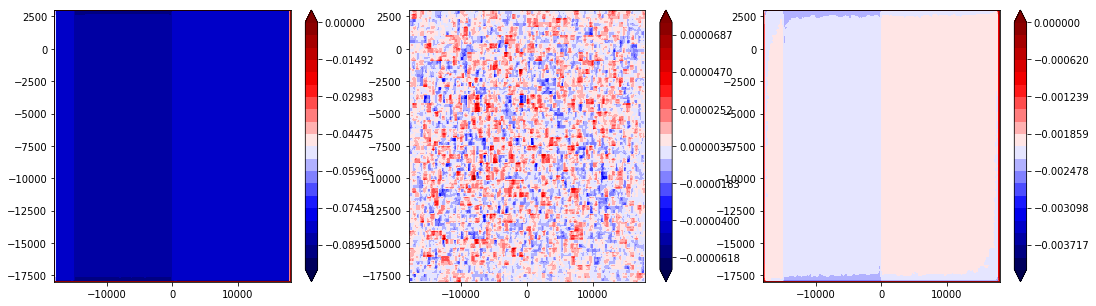

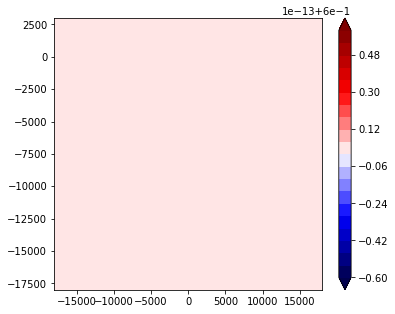

In [14]:
plot_fields(qdm.m, initial_slip)
plot_fields(qdm.m, initial_state)

In [15]:
initial_conditions = np.concatenate((initial_slip, initial_state))
integrator = RK45(derivs, 0, initial_conditions, 1e20, atol = 1e-5, rtol = 1e-5)

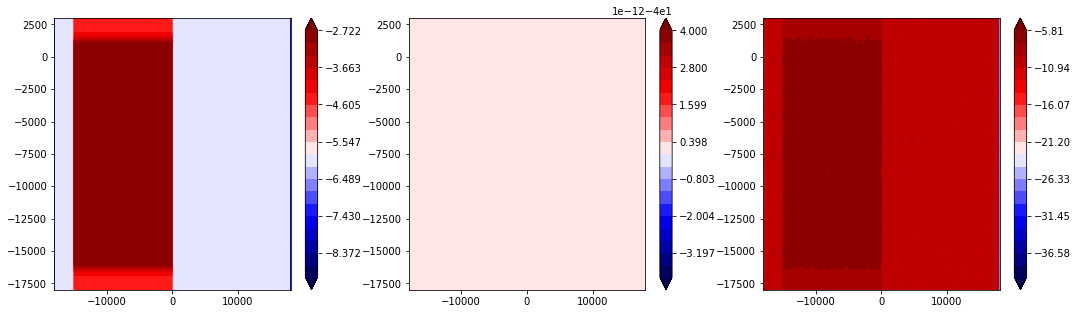

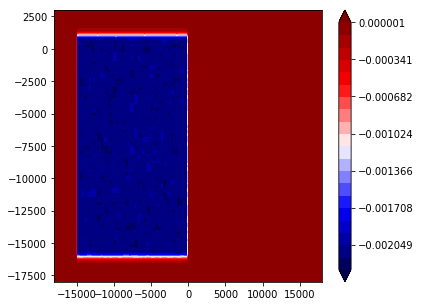

In [16]:
t = integrator.t
y = integrator.y
slip, state = separate_slip_state(y)
slip_deficit = get_slip_deficit(qdm, qd_cfg, t, slip)
traction = slip_to_traction(slip_deficit)
V = rate_state_solve(qdm, qd_cfg, traction, state)
dstatedt = state_evolution(qdm, qd_cfg, V, state)
# plot_fields(qdm.m, slip)
# plot_fields(qdm.m, slip_deficit)
# plot_fields(qdm.m, traction)
plot_fields(qdm.m, np.log10(np.abs(V) + 1e-40))
plot_fields(qdm.m, dstatedt)

0 3.49638118138e-09
slip


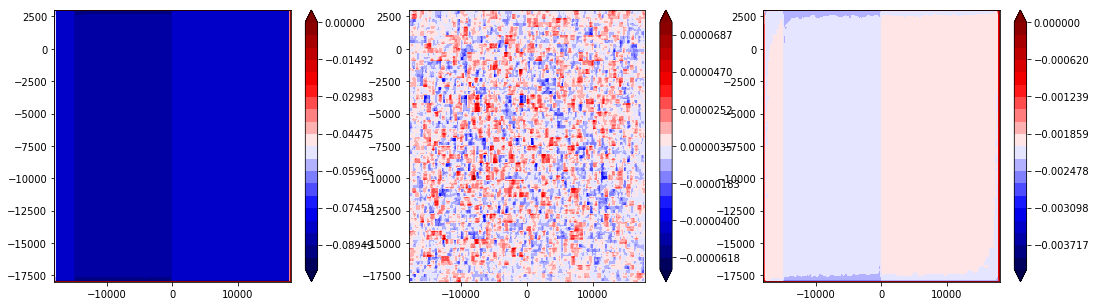

V


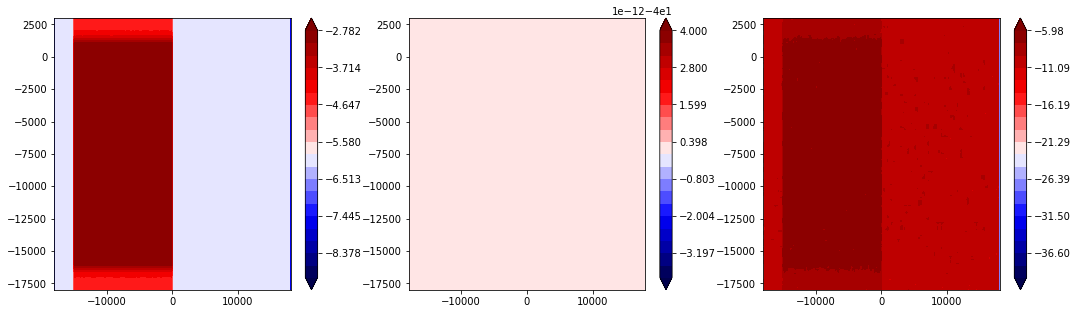

traction


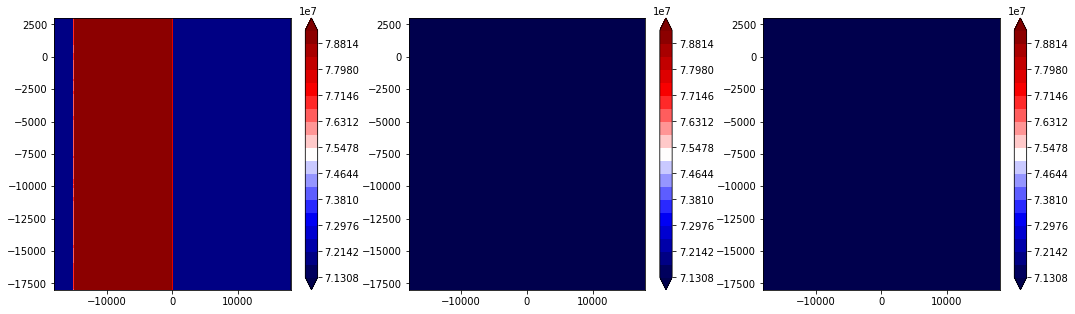

state


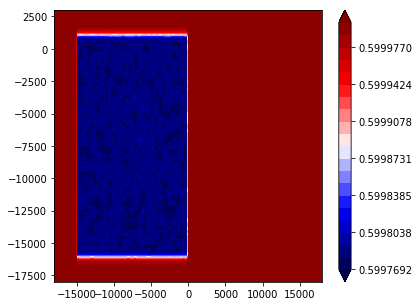

1 8.98821841594e-09
time step vs lapusta 0.173309202713 3.69907568675 108419.001249
2 1.71658164491e-08
time step vs lapusta 0.25806536769 4.63565110132 108419.001249
3 2.89388785898e-08
time step vs lapusta 0.371529585814 5.95497908676 108419.001249
slip


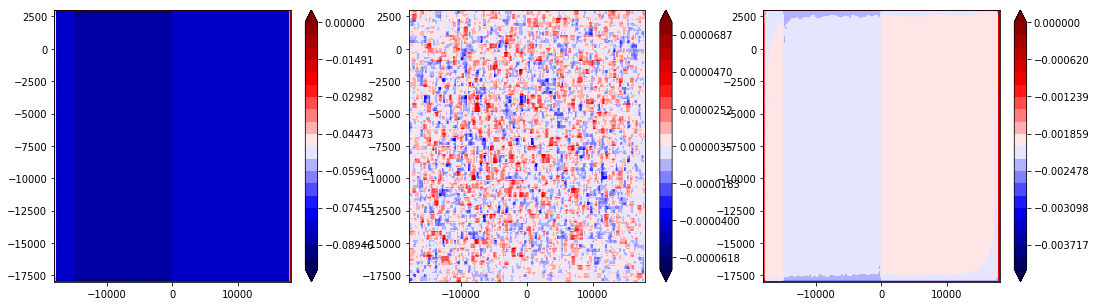

V


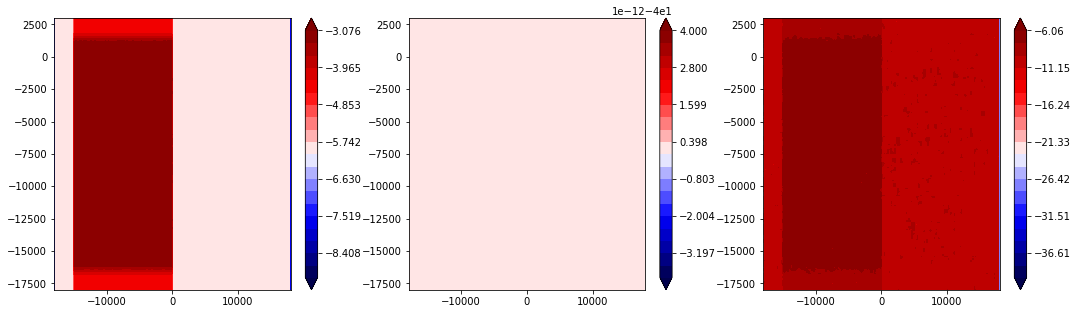

traction


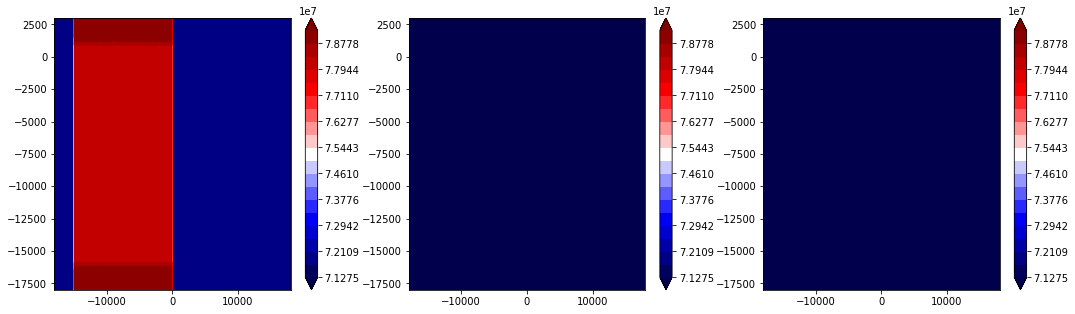

state


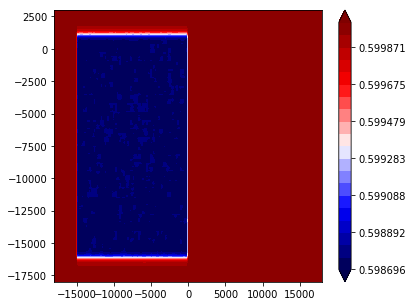

4 4.54607267164e-08
time step vs lapusta 0.521389874439 7.89192654263 108419.001249
5 6.85516943469e-08
time step vs lapusta 0.728695520095 10.3209179396 108419.001249
6 1.0056194312e-07
time step vs lapusta 1.01016662669 13.9773471687 108419.001249
slip


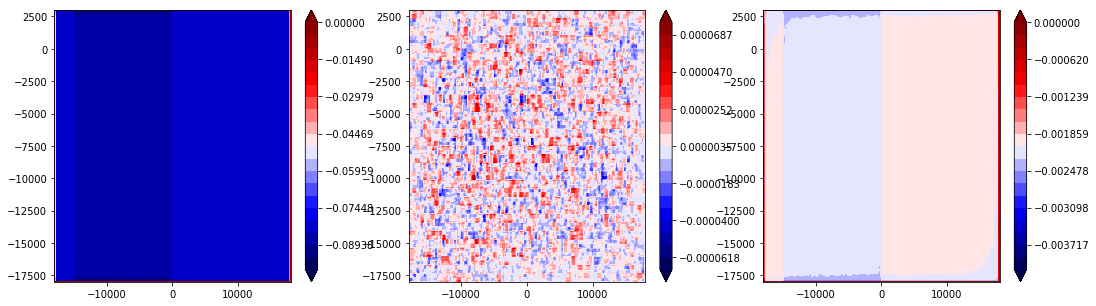

V


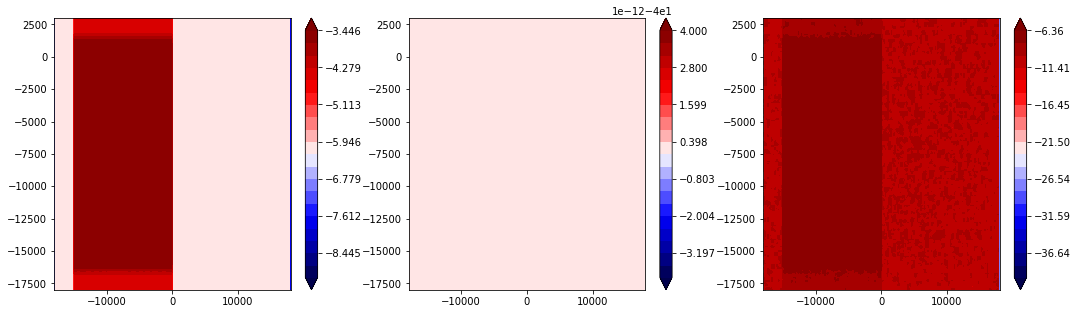

traction


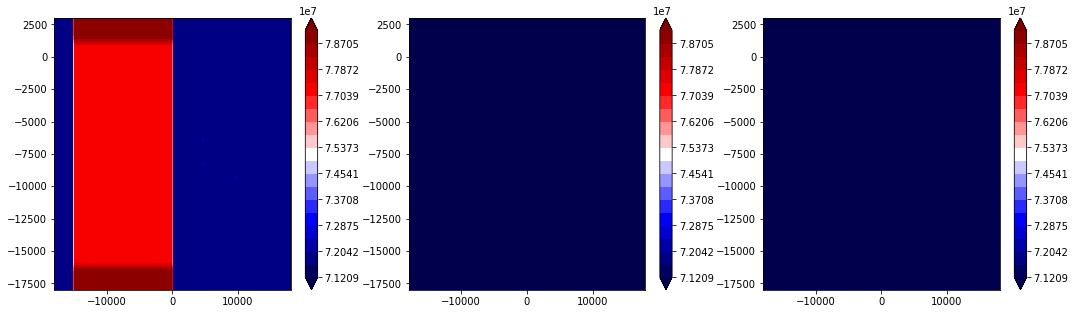

state


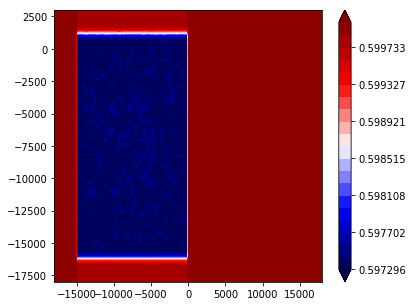

7 1.44461760998e-07
time step vs lapusta 1.38537289268 19.0489189792 108419.001249
8 2.0490542619e-07
time step vs lapusta 1.90745700865 25.9328595566 108419.001249
9 2.88164297366e-07
time step vs lapusta 2.62745015302 35.3009401306 108419.001249
slip


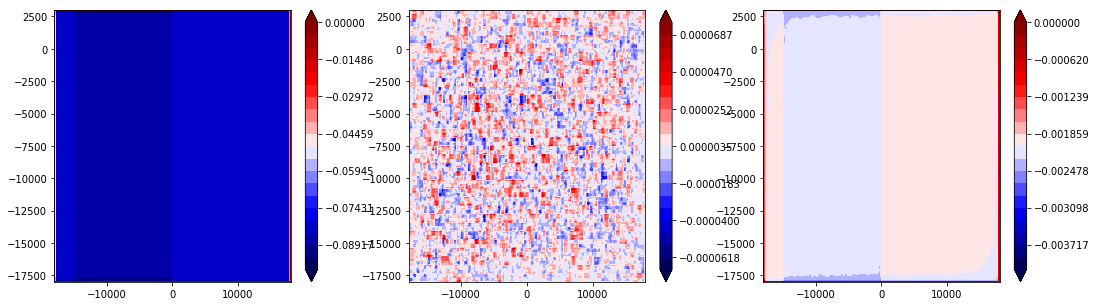

V


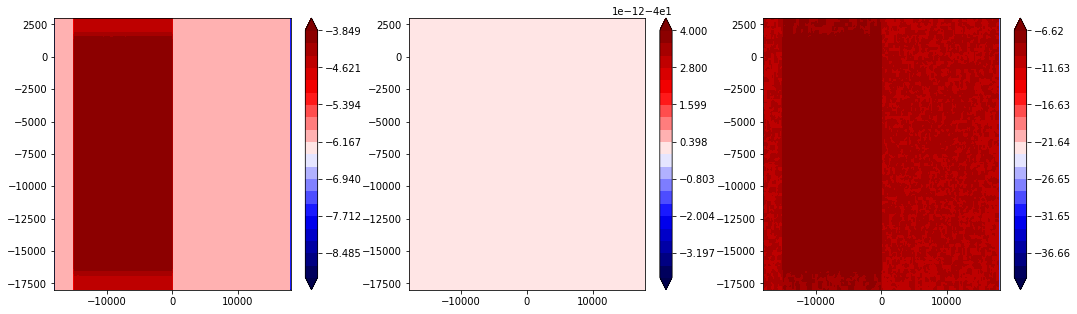

traction


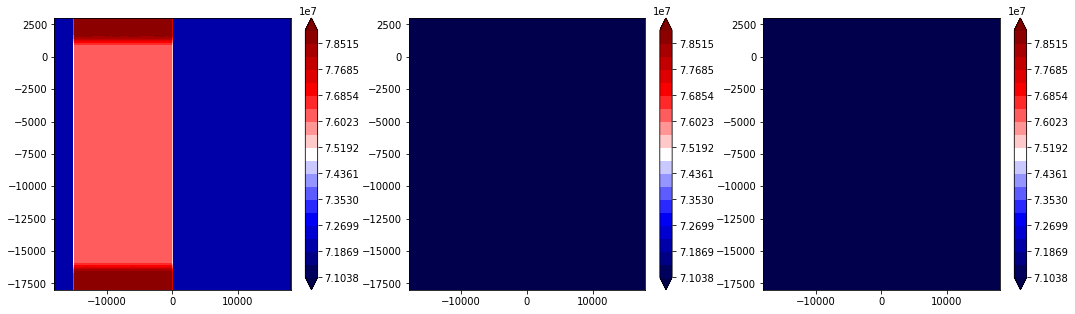

state


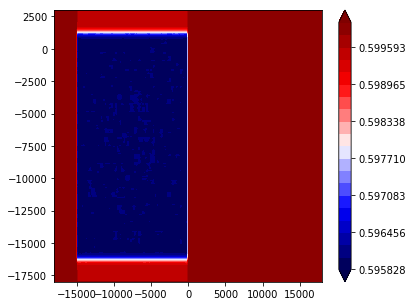

10 4.01915174281e-07
time step vs lapusta 3.58970467333 47.7221590064 108419.001249
11 5.5695307285e-07
time step vs lapusta 4.89262398788 63.1080242875 108419.001249
12 7.68596256442e-07
time step vs lapusta 6.67895093055 83.4742223082 108419.001249
slip


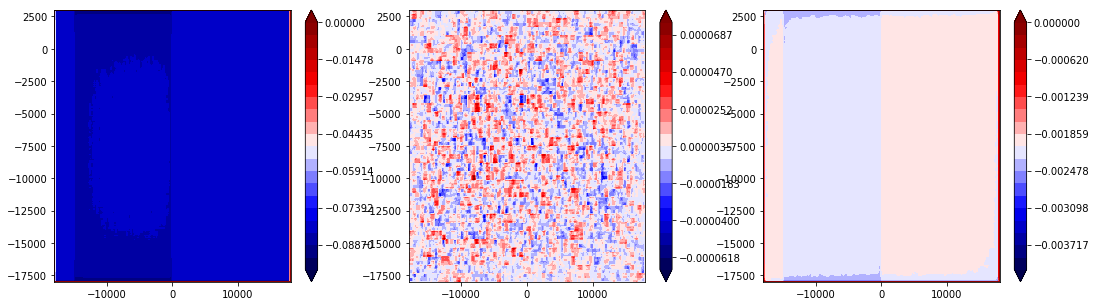

V


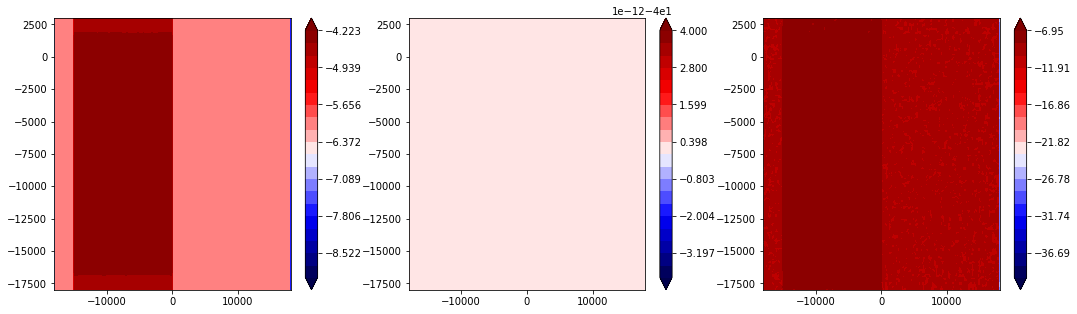

traction


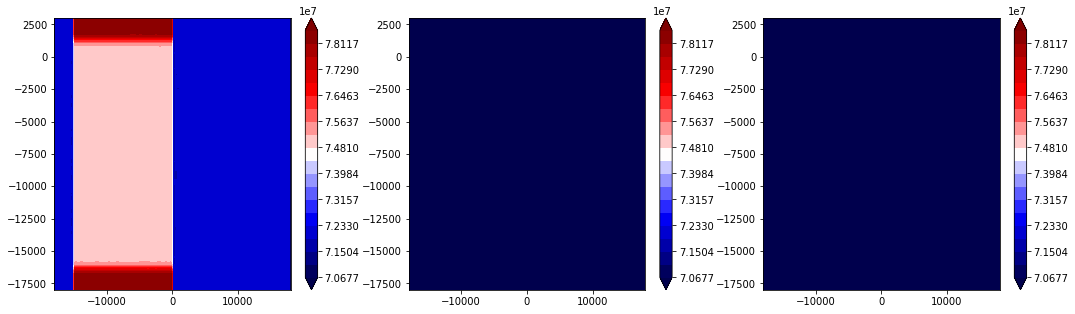

state


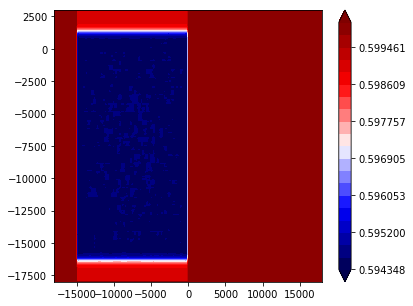

13 1.06001941374e-06
time step vs lapusta 9.19661542879 110.069671867 108419.001249
14 1.45933781058e-06
time step vs lapusta 12.60153024 145.585163094 108419.001249
15 2.00425388485e-06
time step vs lapusta 17.1962435055 190.681203033 108419.001249
slip


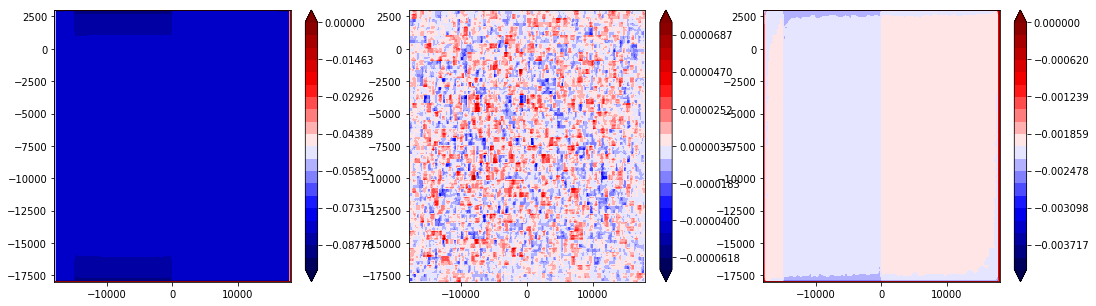

V


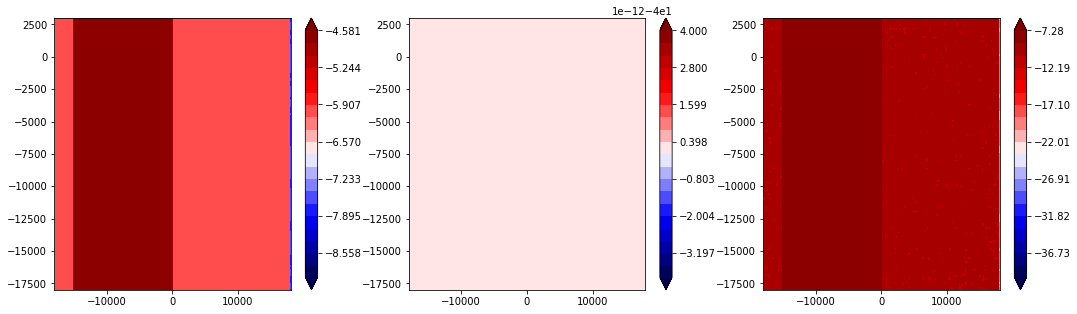

traction


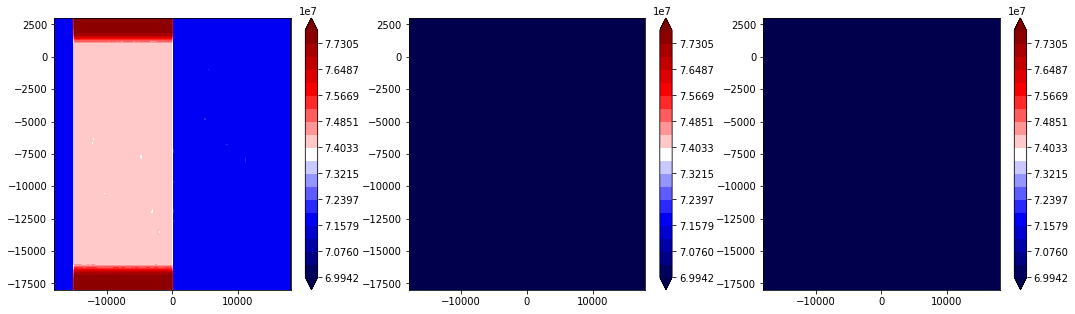

state


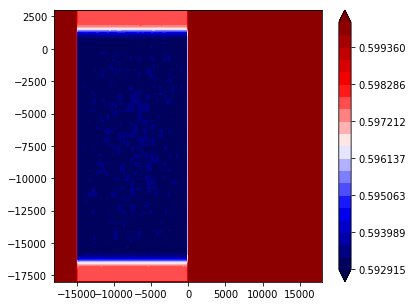

16 2.75413558561e-06
time step vs lapusta 23.6644667599 248.403807704 108419.001249
17 3.77836737294e-06
time step vs lapusta 32.3222970519 316.859113441 108419.001249
18 5.18943211173e-06
time step vs lapusta 44.5298166007 389.421156468 108419.001249
slip


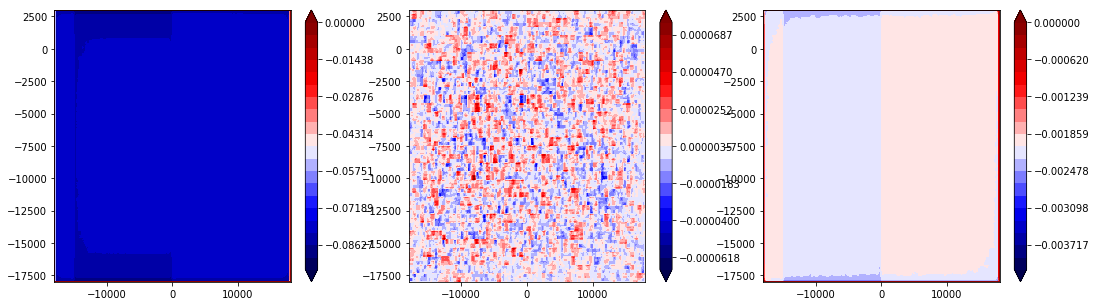

V


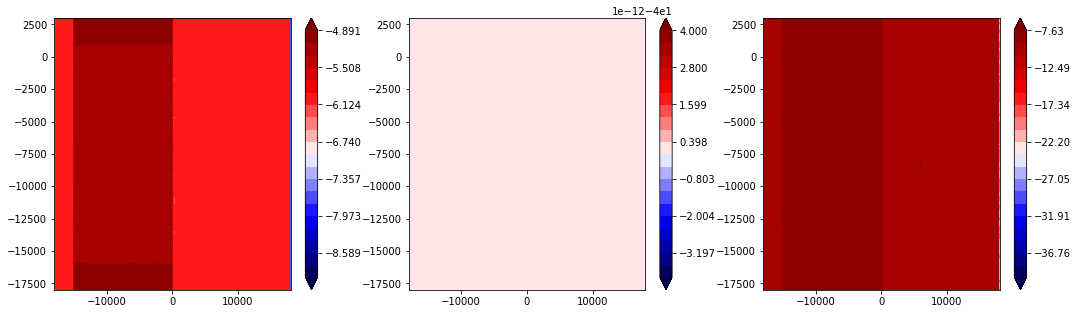

traction


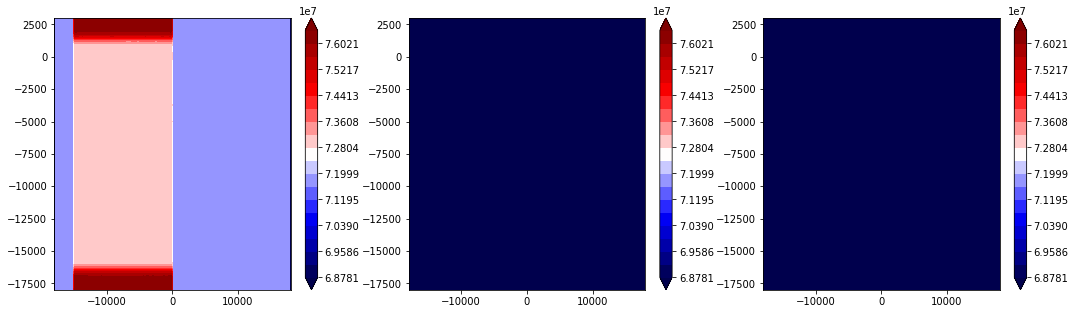

state


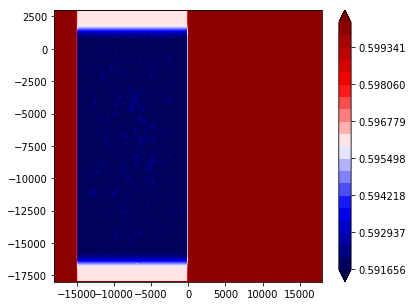

19 7.12843532878e-06
time step vs lapusta 61.1902879223 492.294629377 108419.001249
20 9.78870312061e-06
time step vs lapusta 83.9516668674 636.150180182 108419.001249
21 1.34491323346e-05
time step vs lapusta 115.514360965 834.874057472 108419.001249
slip


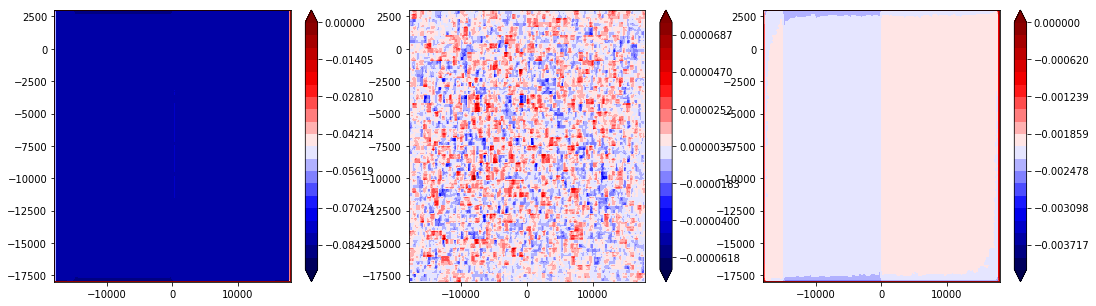

V


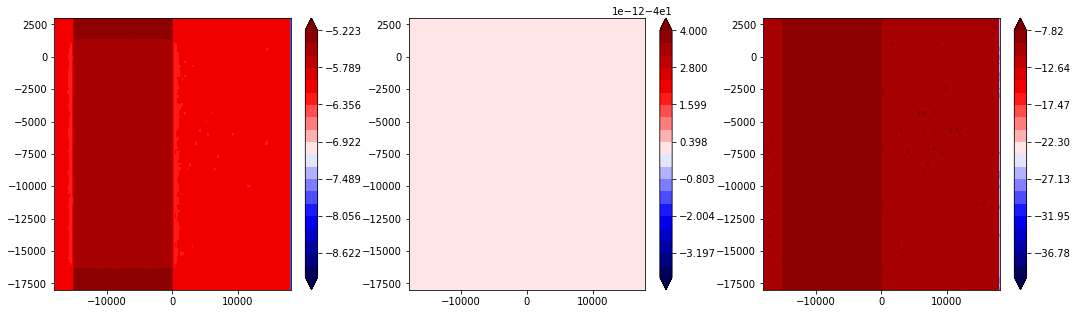

traction


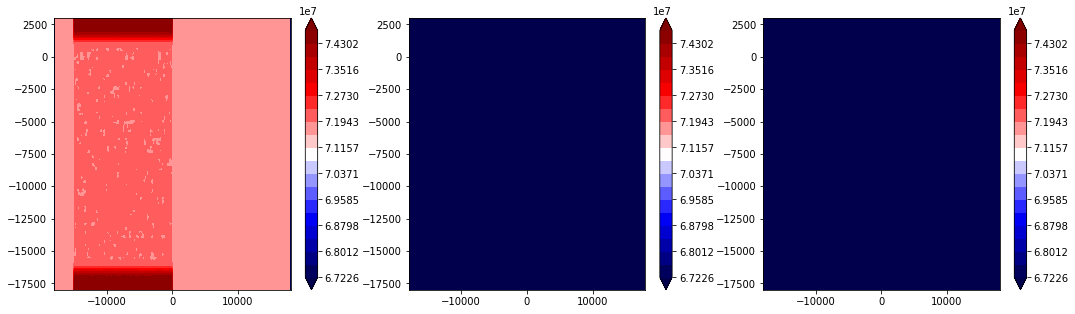

state


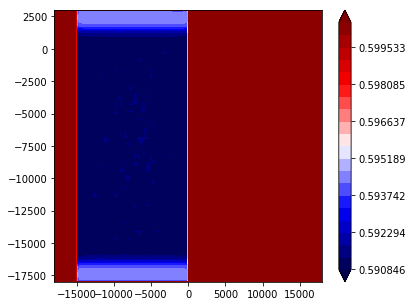

22 1.84867337729e-05
time step vs lapusta 158.974611147 1109.76619528 108419.001249
23 2.54009288761e-05
time step vs lapusta 218.195403389 1506.50523893 108419.001249
24 3.49709205287e-05
time step vs lapusta 302.005968575 2073.79930737 108419.001249
slip


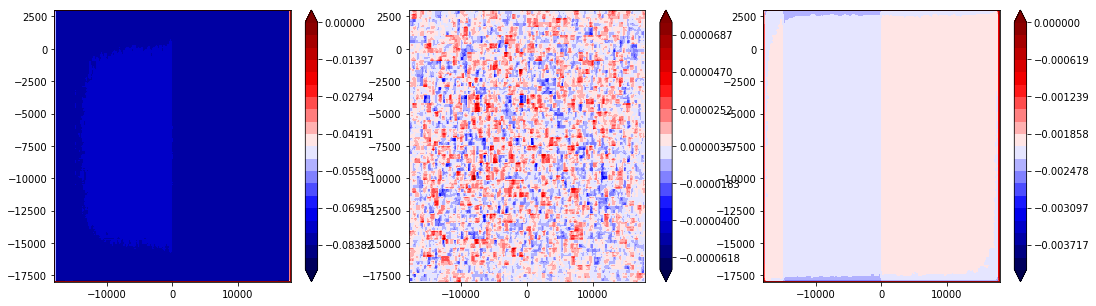

V


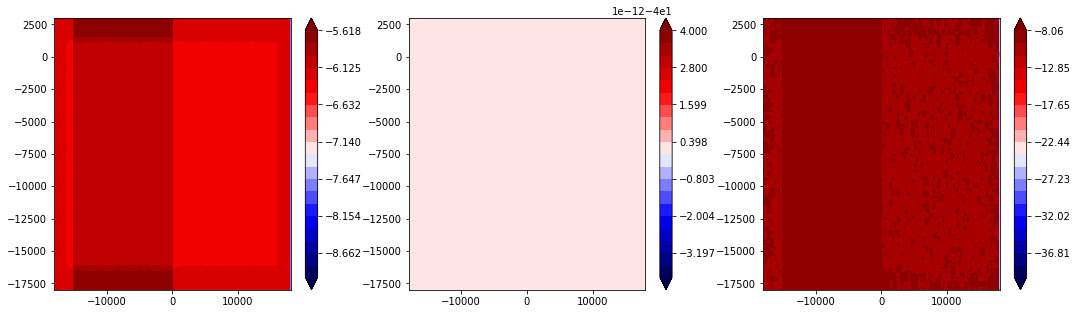

traction


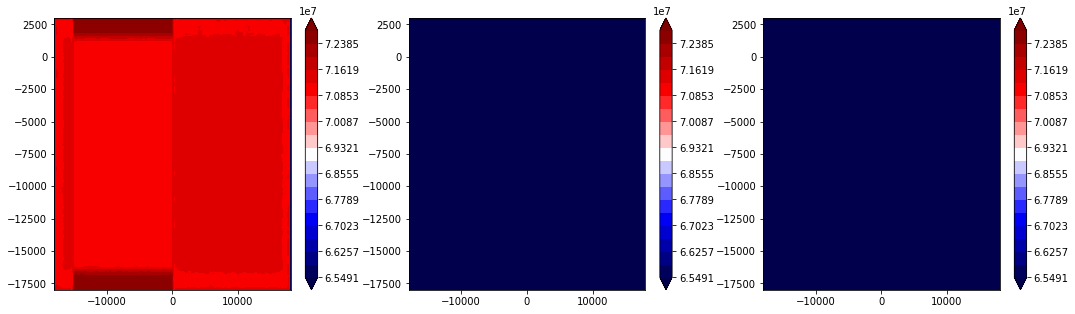

state


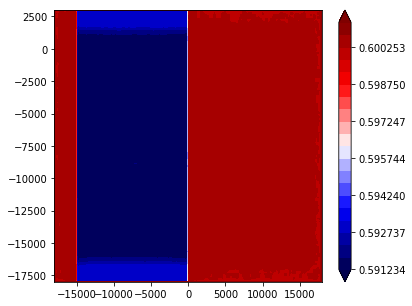

25 4.81876298082e-05
time step vs lapusta 417.087624758 2927.60996187 108419.001249
26 6.65071553954e-05
time step vs lapusta 578.120260672 4155.83052255 108419.001249
27 9.20742702274e-05
time step vs lapusta 806.836783024 6007.60645878 108419.001249
slip


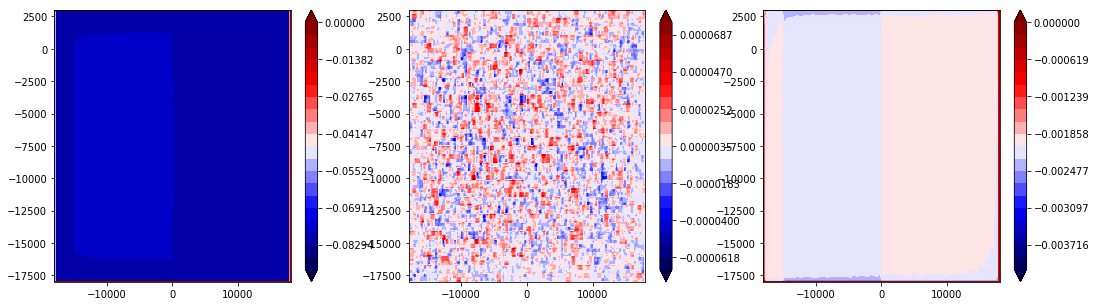

V


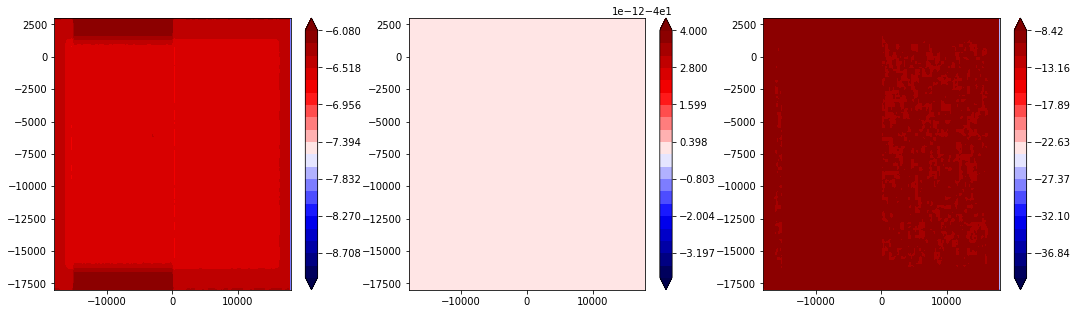

traction


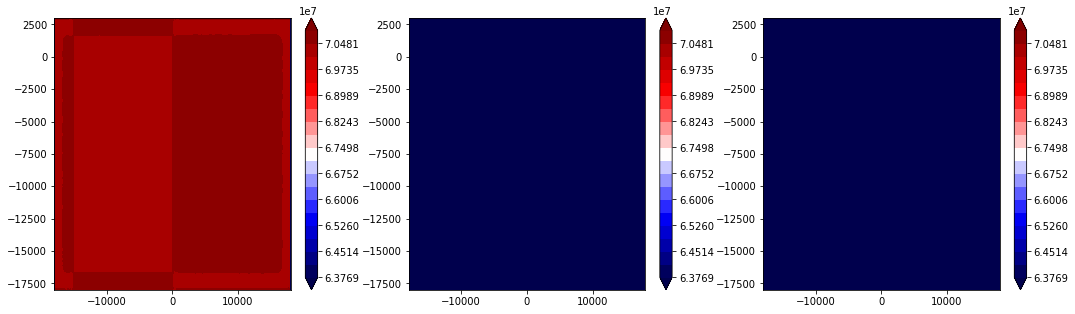

state


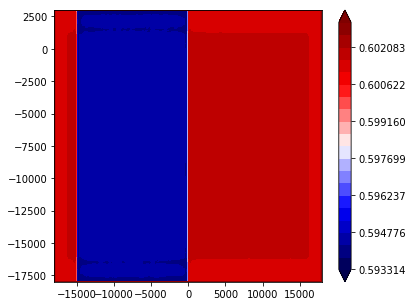

28 0.000127910787957
time step vs lapusta 1130.91449191 8895.69691973 108419.001249
29 0.000178512526673
time step vs lapusta 1596.86942969 13637.2062644 108419.001249
30 0.000250806188705
time step vs lapusta 2281.41446895 20712.0428106 108419.001249
slip


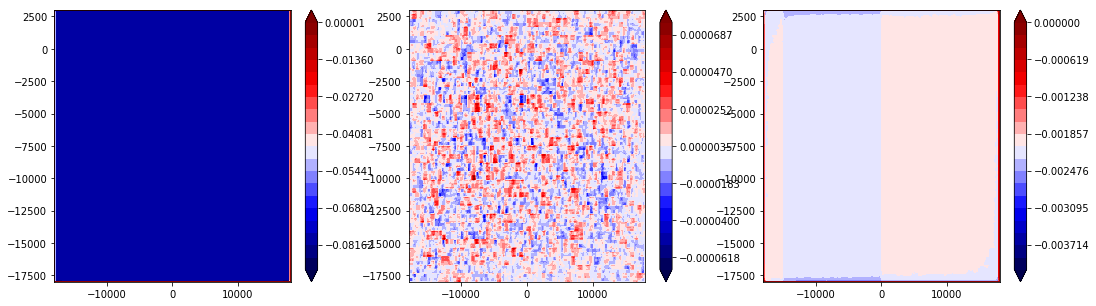

V


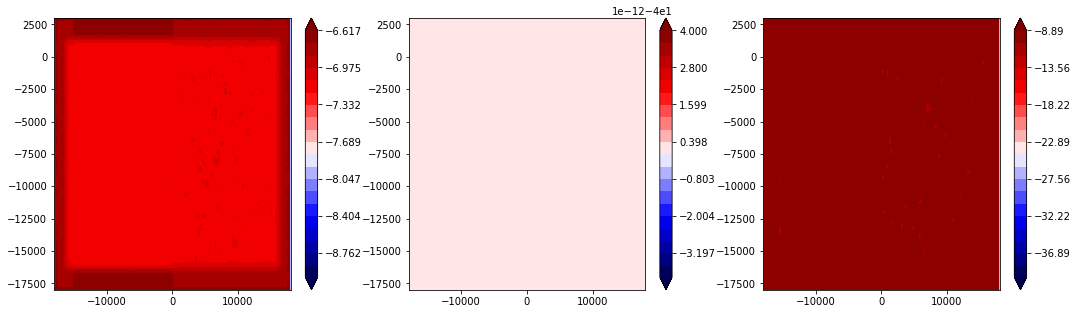

traction


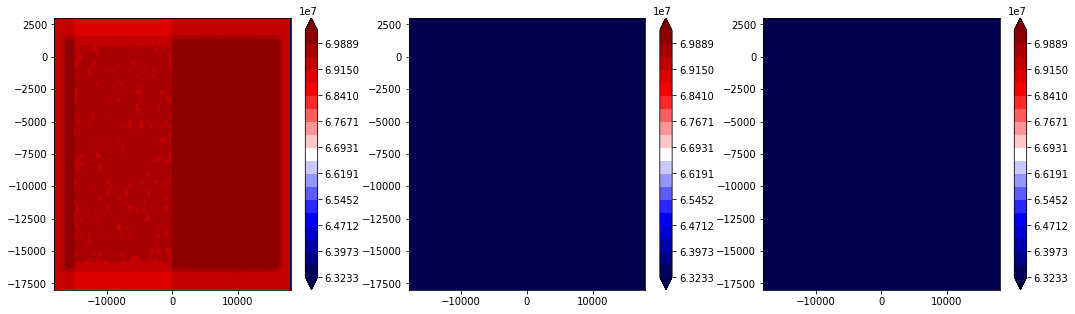

state


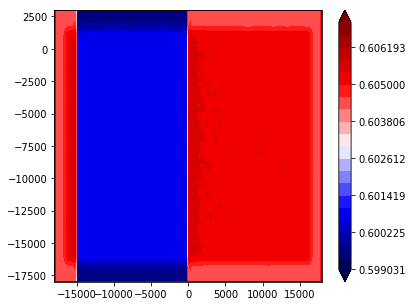

31 0.000356090440355
time step vs lapusta 3322.51829986 32711.744024 108419.001249
32 0.000512259676412
time step vs lapusta 4928.32628379 51132.2087274 108419.001249
33 0.000749160242108
time step vs lapusta 7476.01329201 78430.1668028 108419.001249
slip


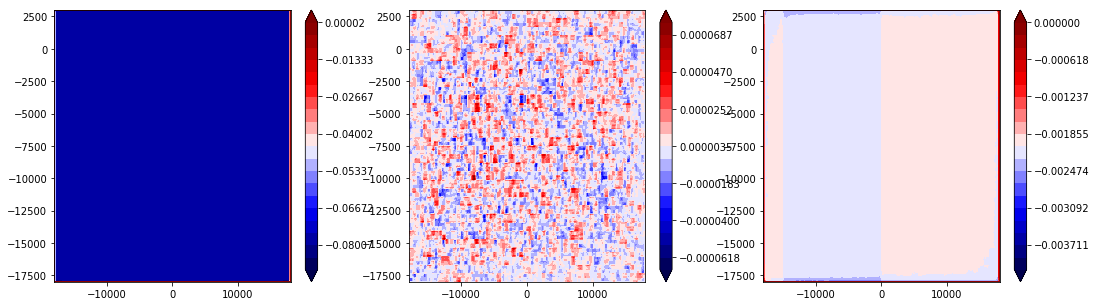

V


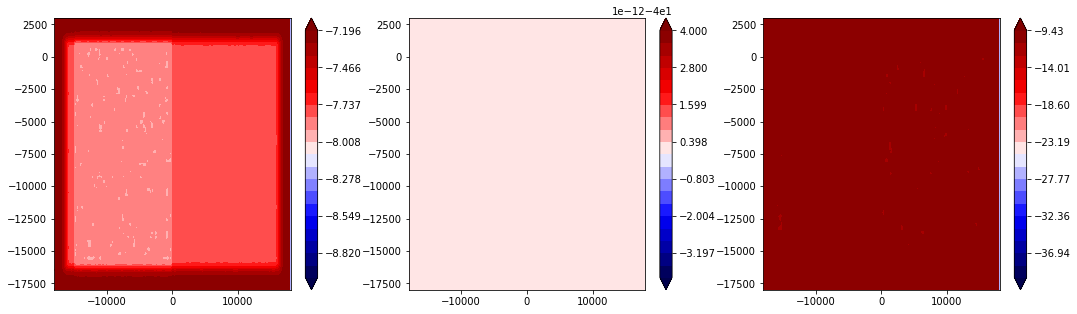

traction


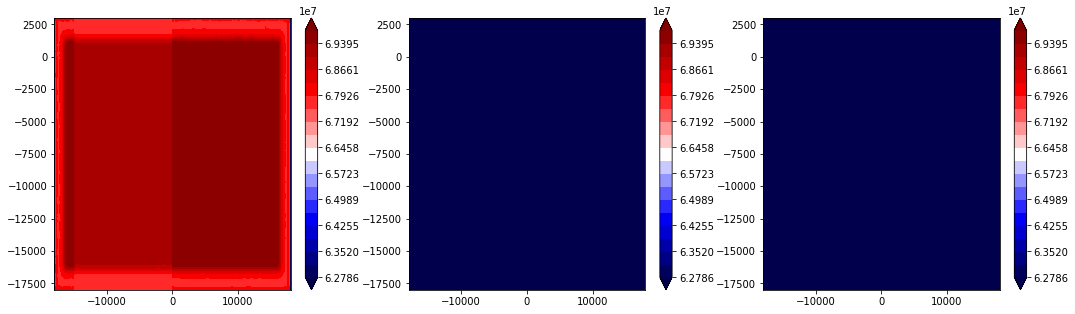

state


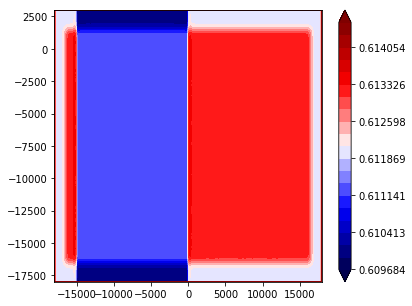

34 0.0011161683399
time step vs lapusta 11581.894747 124359.975058 108419.001249
35 0.0017033647227
time step vs lapusta 18530.5085697 203299.250797 108419.001249
36 0.0026617198091
time step vs lapusta 30243.3864748 341833.560792 108419.001249
slip


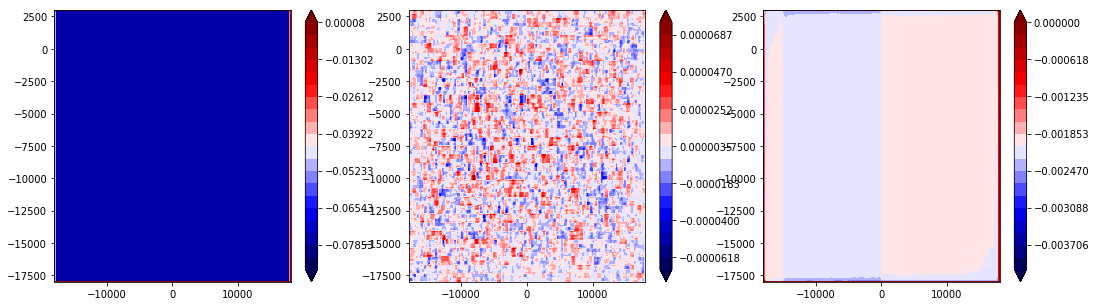

V


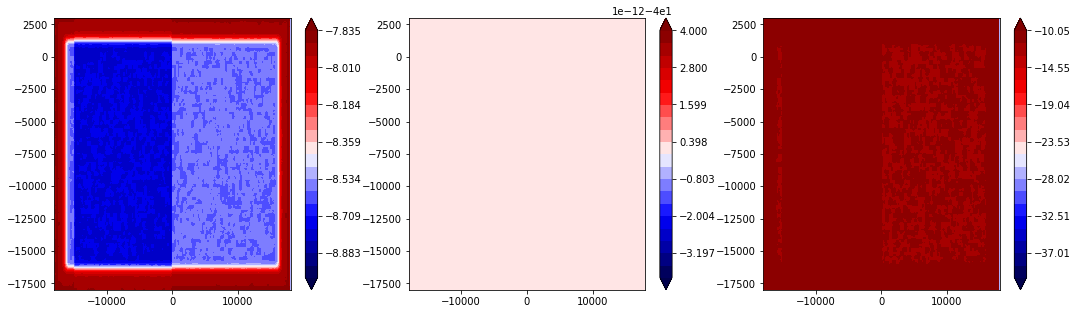

traction


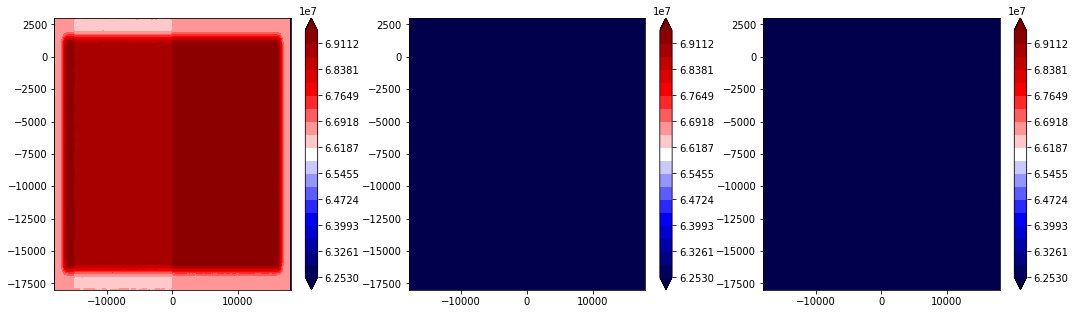

state


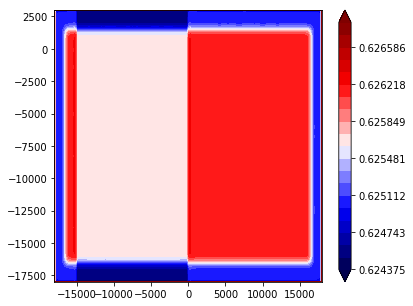

37 0.00424732328734
time step vs lapusta 50037.840325 584499.243447 108419.001249
38 0.00686996033099
time step vs lapusta 82764.1307684 998549.521234 108419.001249
39 0.0111733431894
time step vs lapusta 135804.434891 1651948.77102 108419.001249
slip


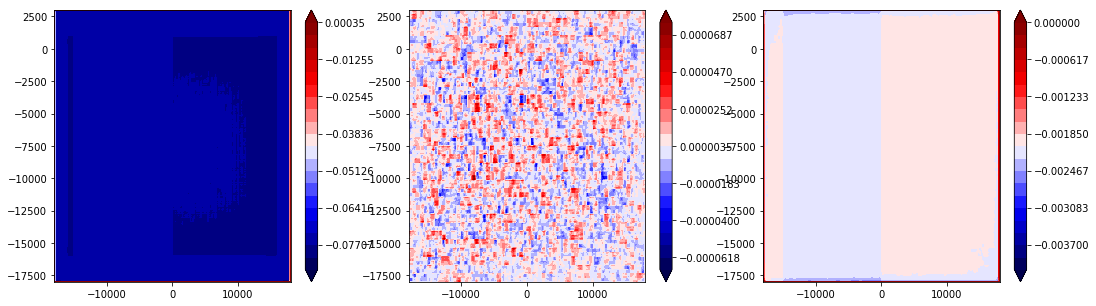

V


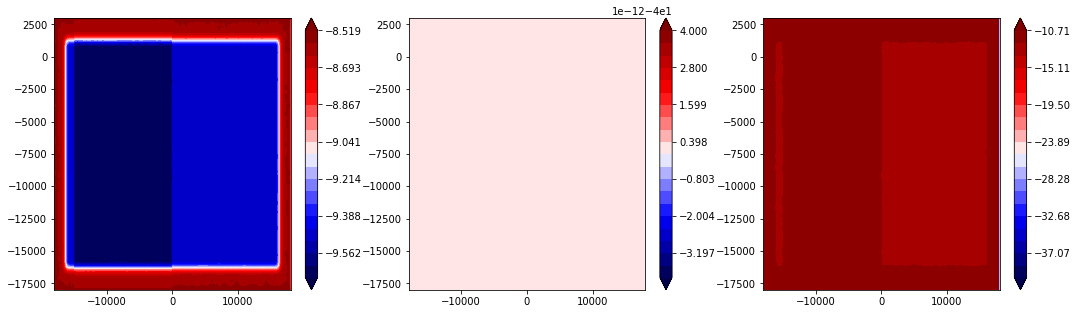

traction


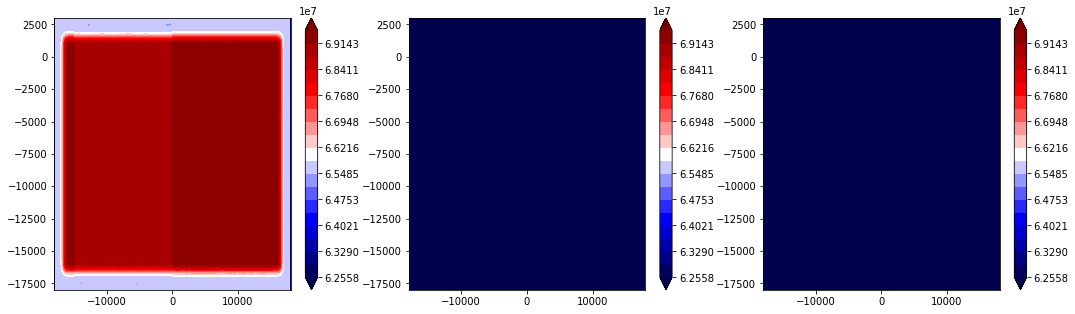

state


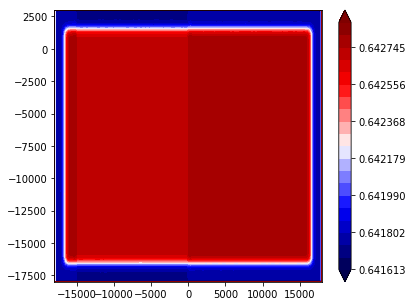

40 0.0182078406654
time step vs lapusta 221991.85755 2666265.15736 108419.001249
41 0.0295847911446
time step vs lapusta 359029.252443 4099318.70601 108419.001249
42 0.0480042209246
time step vs lapusta 581272.997224 5000000.0 108419.001249
slip


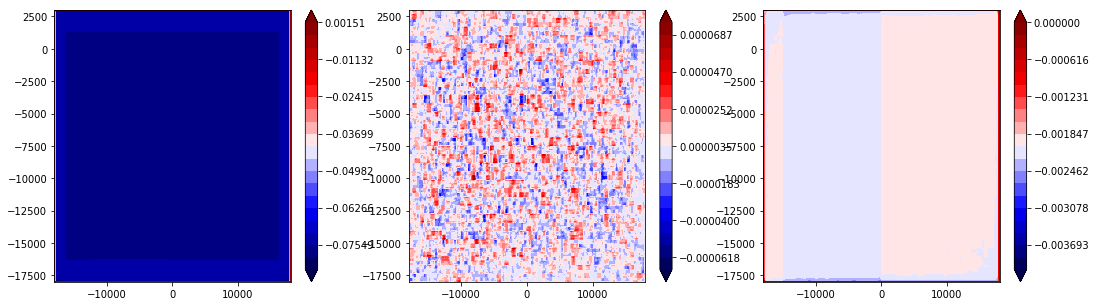

V


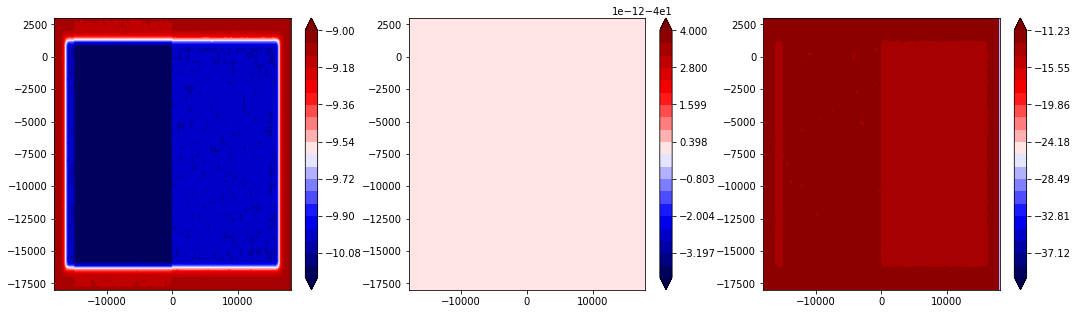

traction


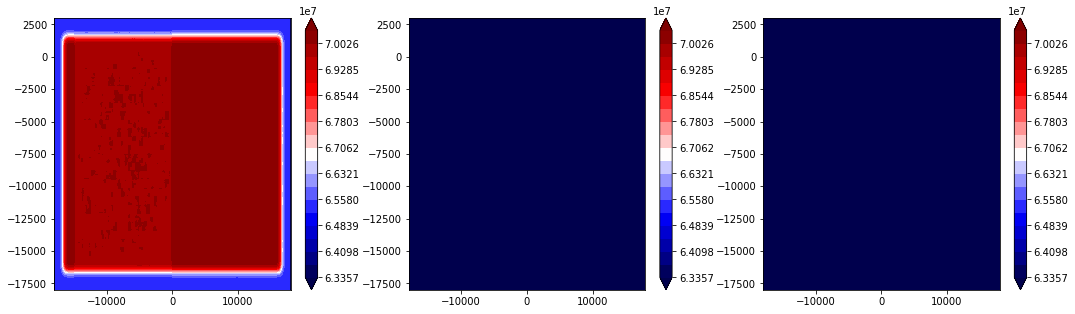

state


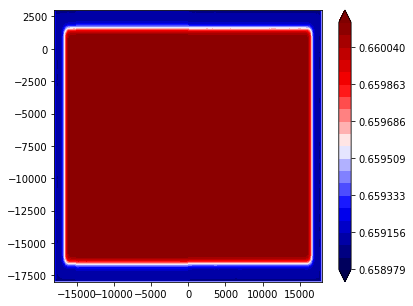

43 0.0773960864391
time step vs lapusta 927536.735162 5000000.0 108419.001249
44 0.122790067467
time step vs lapusta 1432525.09567 5000000.0 108419.001249
45 0.184818595097
time step vs lapusta 1957471.46355 5000000.0 108419.001249
slip


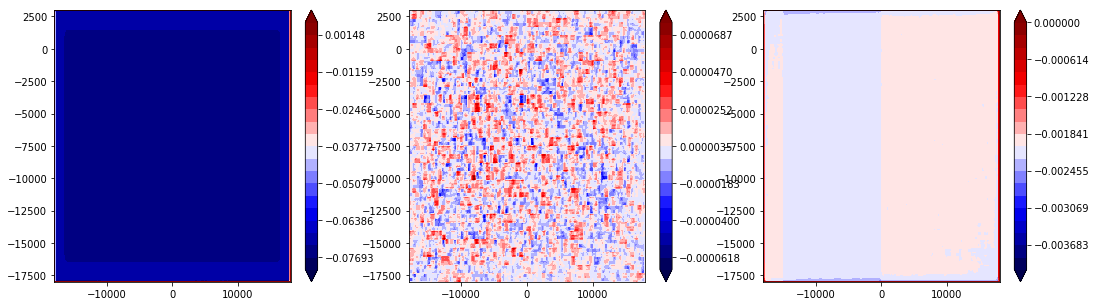

V


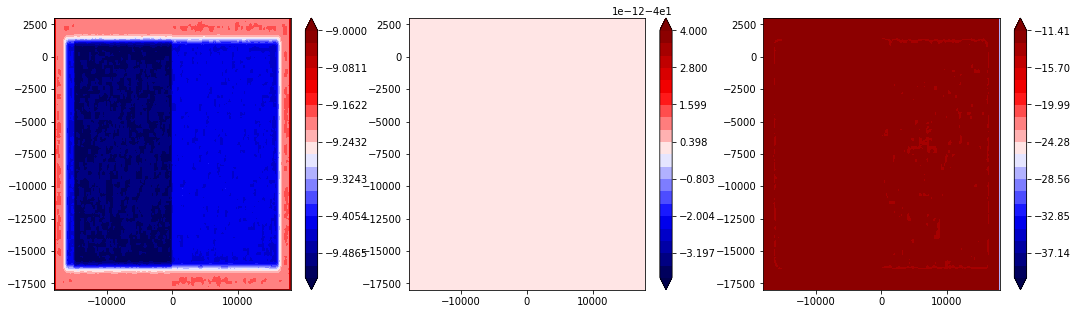

traction


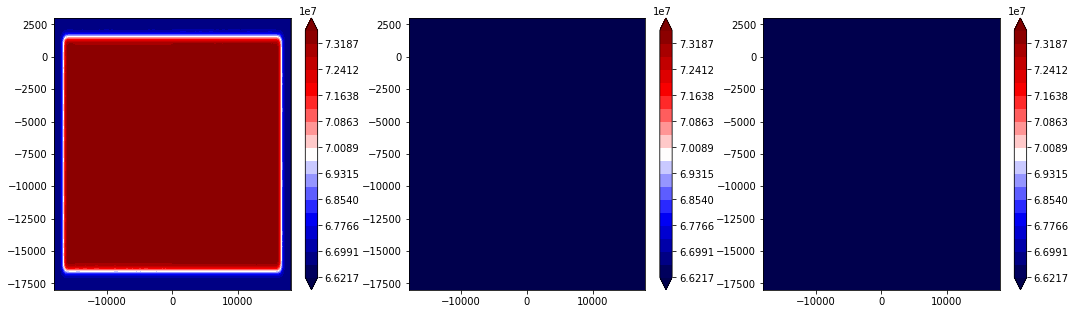

state


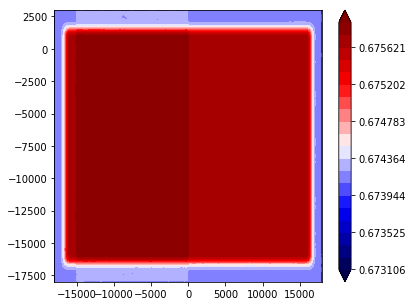

46 0.253690823478
time step vs lapusta 2173442.23436 5000000.0 108419.001249
47 0.297078433078
time step vs lapusta 1369208.82872 5000000.0 108419.001249
48 0.340466042678
time step vs lapusta 1369208.82872 5000000.0 108419.001249
slip


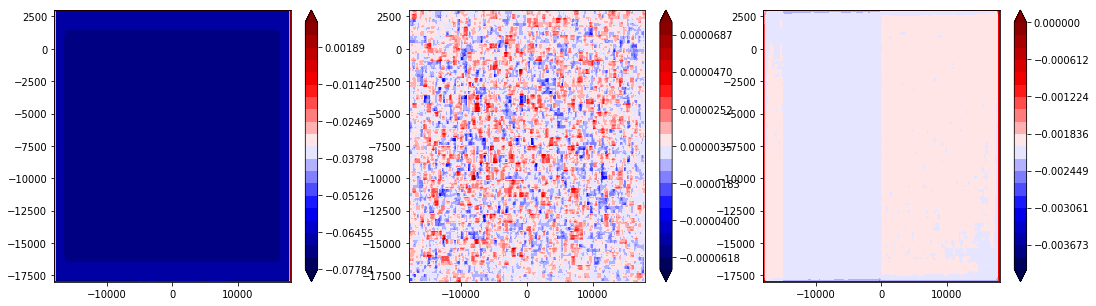

V


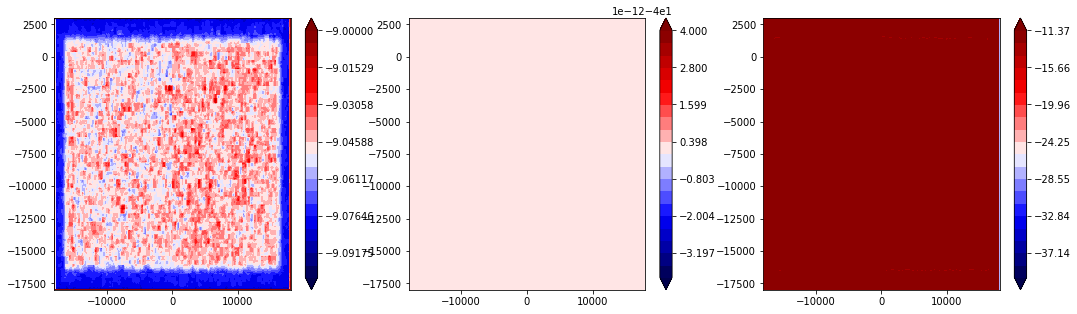

traction


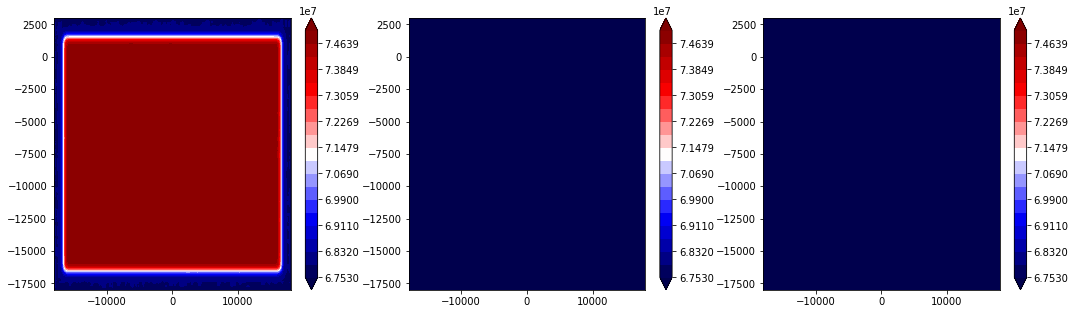

state


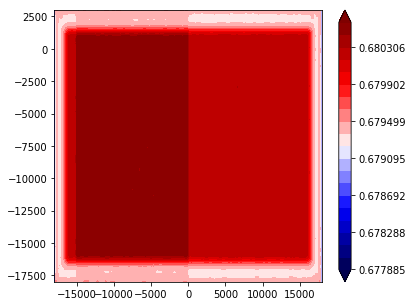

49 0.383853652279
time step vs lapusta 1369208.82872 4937944.39964 108419.001249
50 0.427241261879
time step vs lapusta 1369208.82872 4812262.45206 108419.001249
51 0.465723757157
time step vs lapusta 1214415.19298 4822229.54342 108419.001249
slip


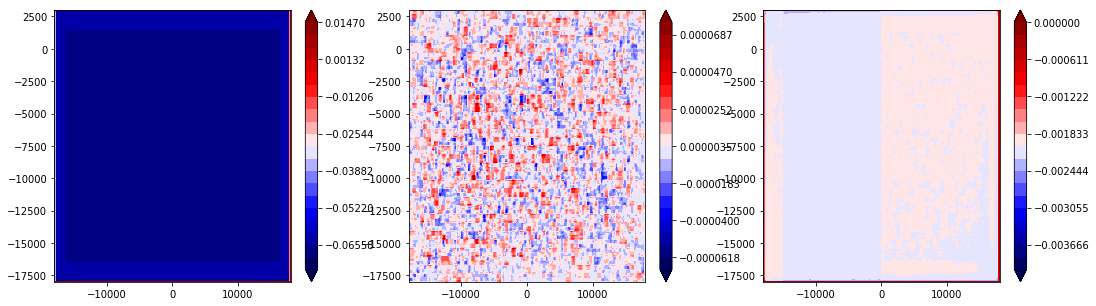

V


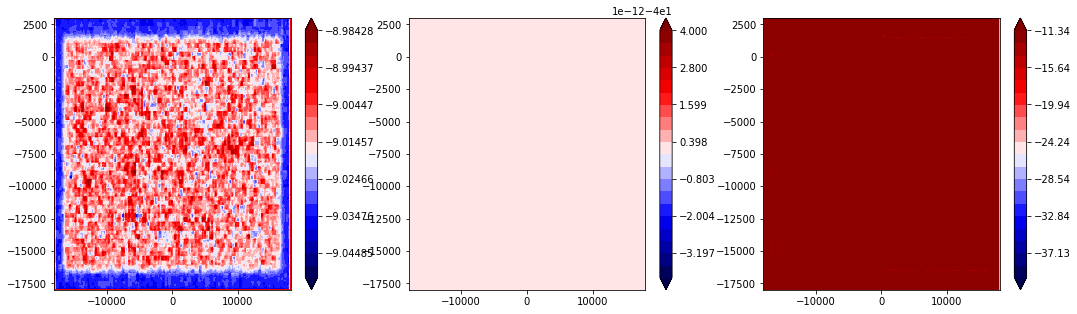

traction


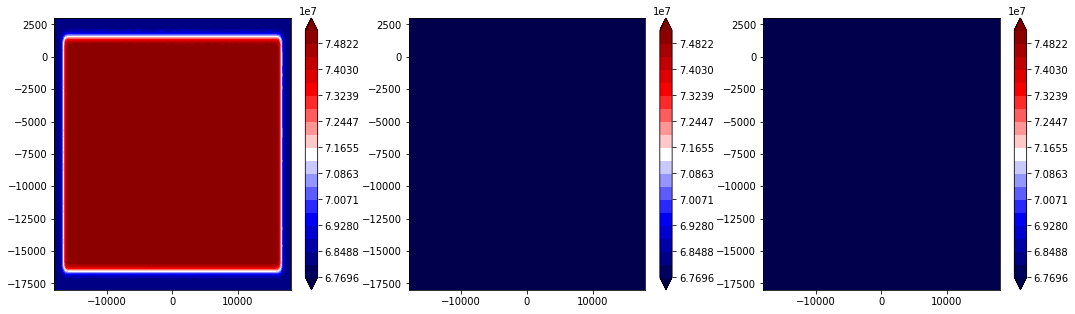

state


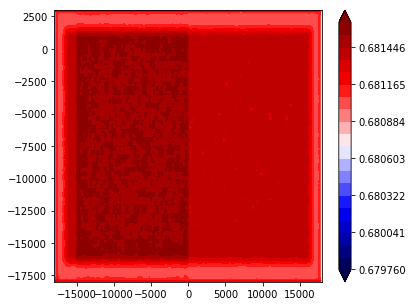

52 0.504206252434
time step vs lapusta 1214415.19298 4698651.422 108419.001249
53 0.542688747712
time step vs lapusta 1214415.19298 4754011.3616 108419.001249
54 0.58117124299
time step vs lapusta 1214415.19298 4736003.16409 108419.001249
slip


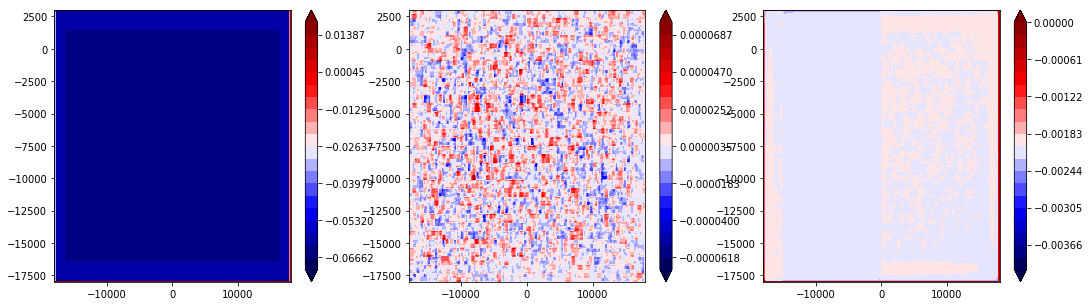

V


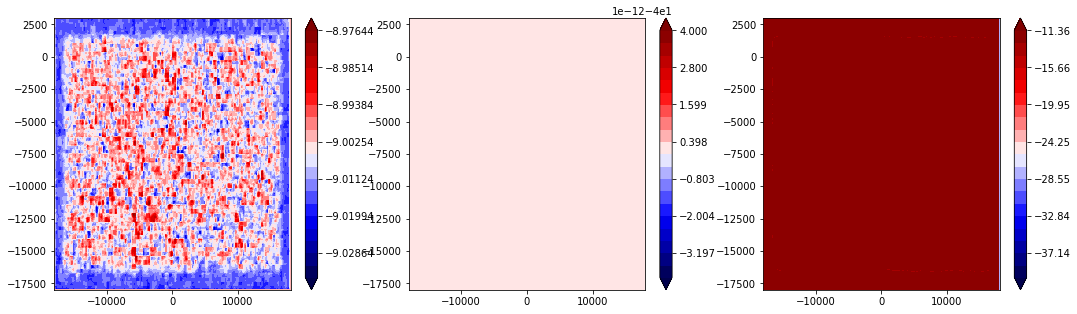

traction


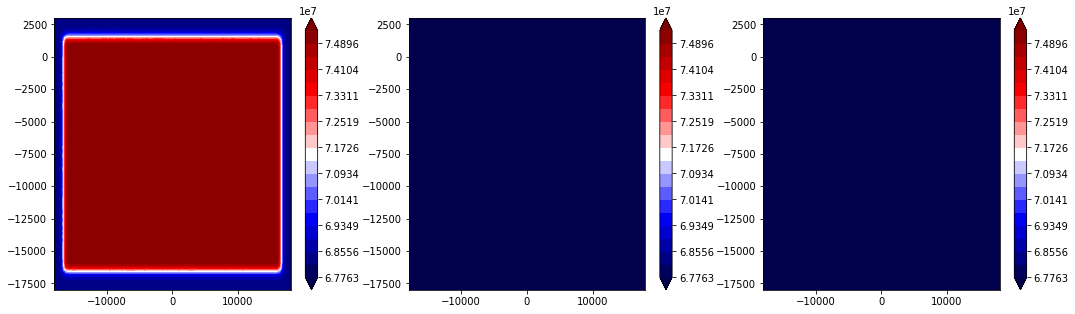

state


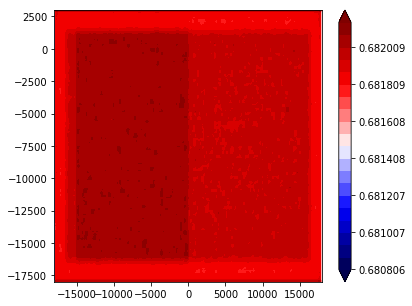

55 0.619653738268
time step vs lapusta 1214415.19298 4685321.60728 108419.001249
56 0.658136233546
time step vs lapusta 1214415.19298 4680812.39708 108419.001249
57 0.696618728824
time step vs lapusta 1214415.19298 4696144.26687 108419.001249
slip


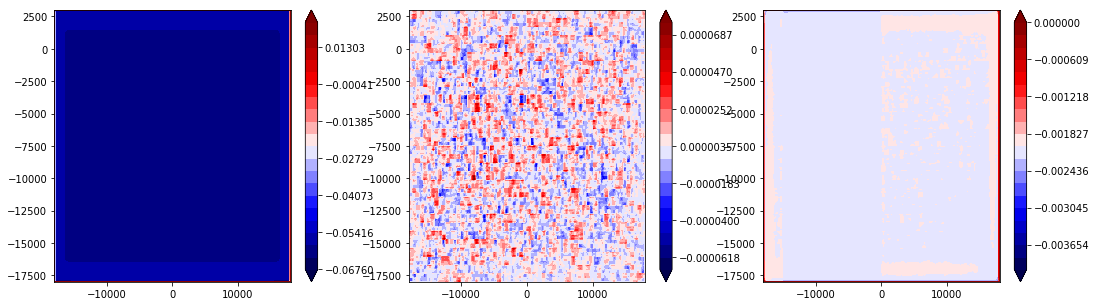

V


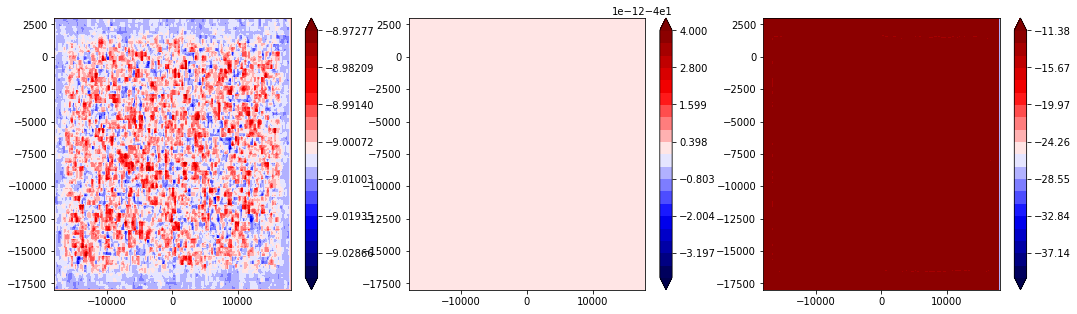

traction


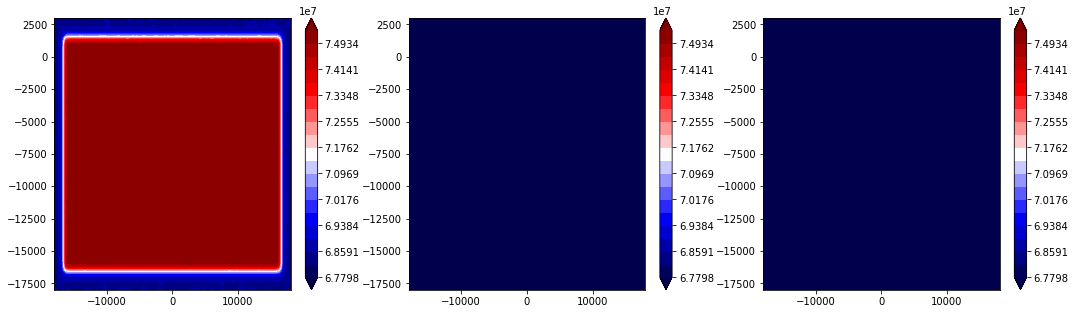

state


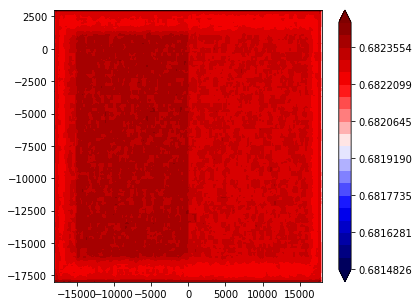

58 0.735101224102
time step vs lapusta 1214415.19298 4643756.8312 108419.001249
59 0.77358371938
time step vs lapusta 1214415.19298 4637218.27027 108419.001249
60 0.812066214658
time step vs lapusta 1214415.19298 4699633.09876 108419.001249
slip


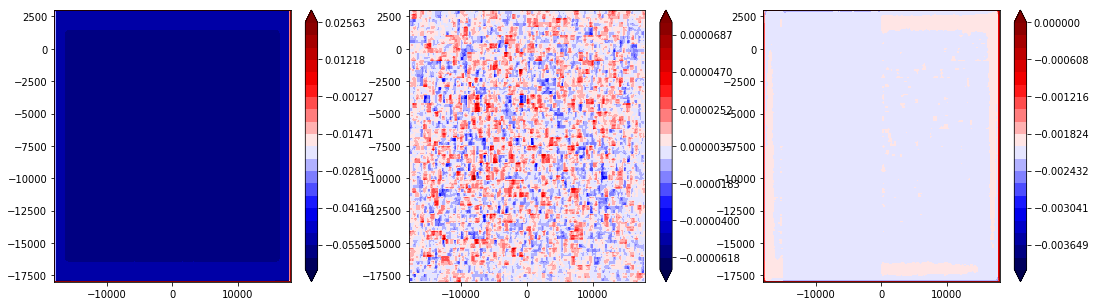

V


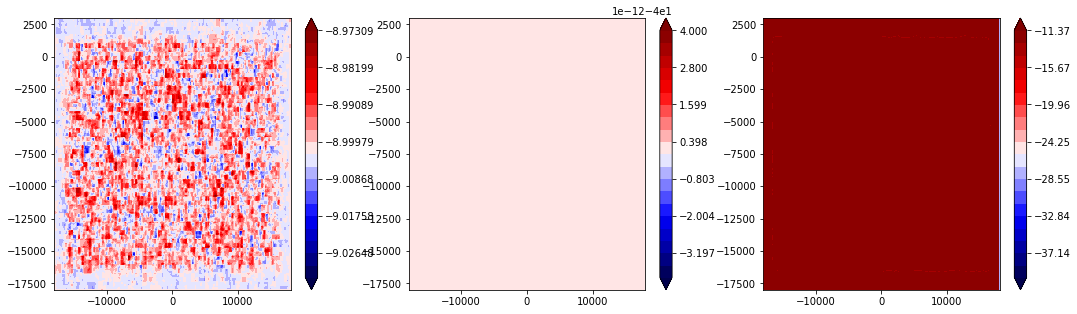

traction


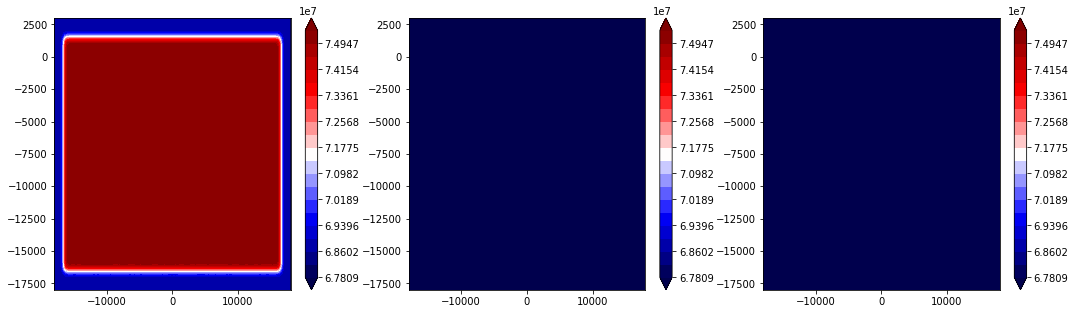

state


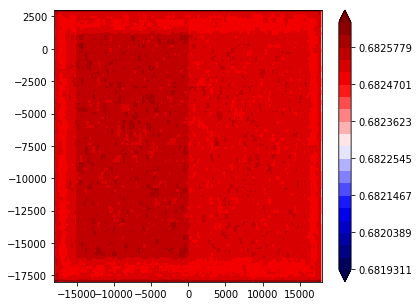

61 0.850548709936
time step vs lapusta 1214415.19298 4666334.24446 108419.001249
62 0.889031205213
time step vs lapusta 1214415.19298 4597495.90302 108419.001249
63 0.927513700491
time step vs lapusta 1214415.19298 4630668.71205 108419.001249
slip


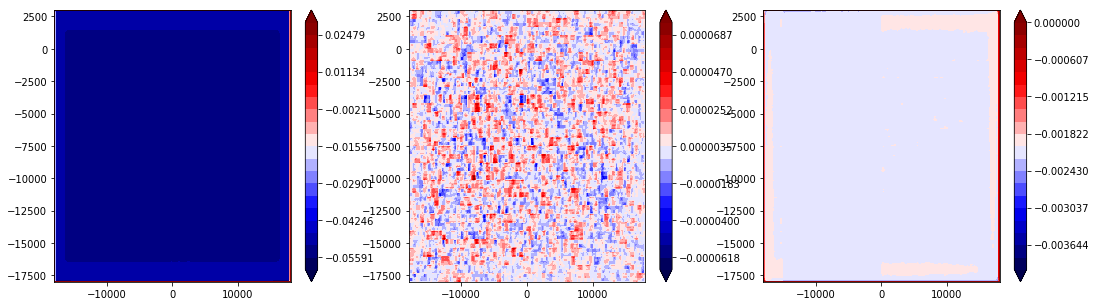

V


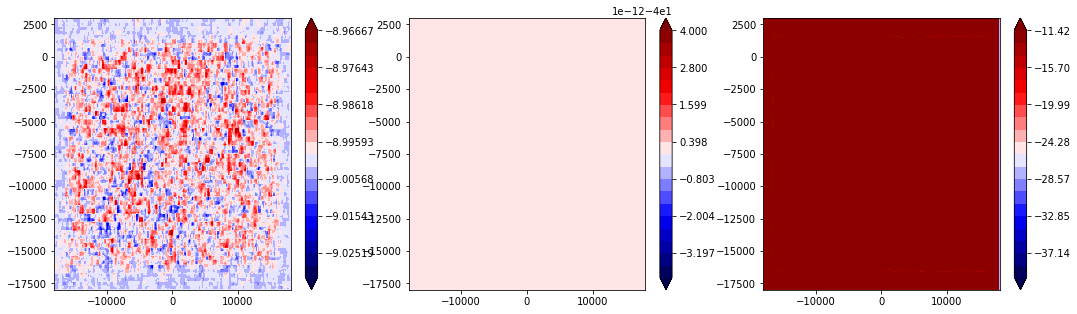

traction


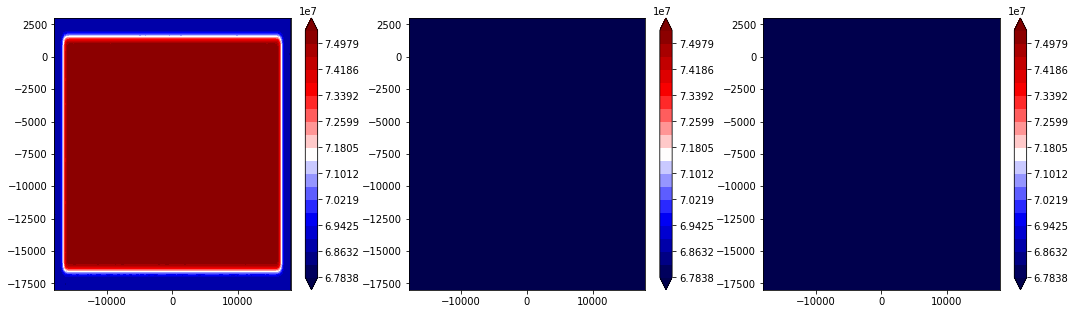

state


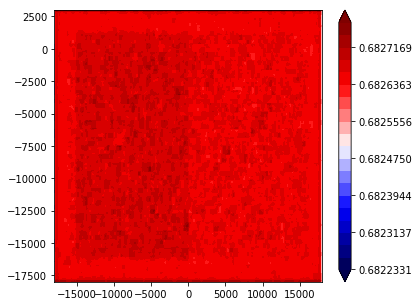

64 0.965996195769
time step vs lapusta 1214415.19298 4627477.32953 108419.001249
65 1.00447869105
time step vs lapusta 1214415.19298 4601739.00199 108419.001249
66 1.04296118633
time step vs lapusta 1214415.19298 4636924.19388 108419.001249
slip


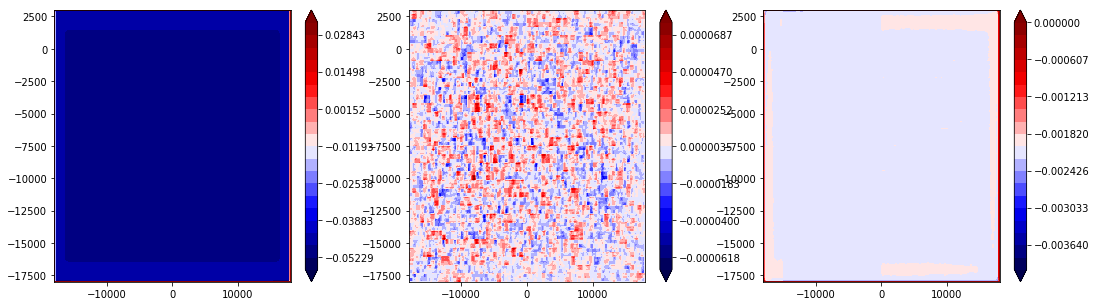

V


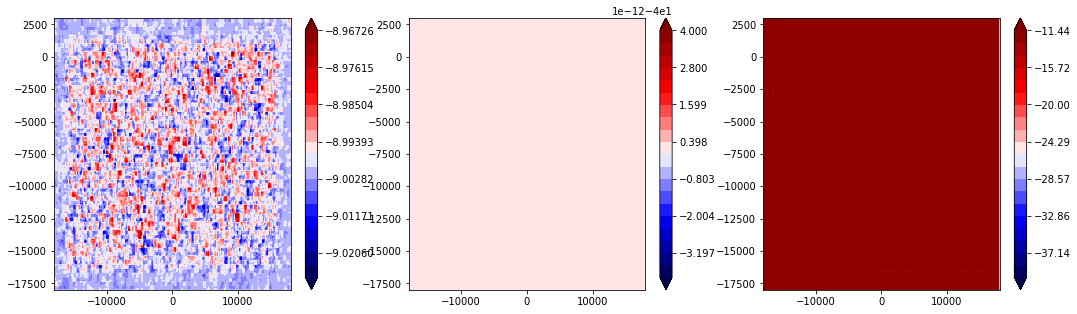

traction


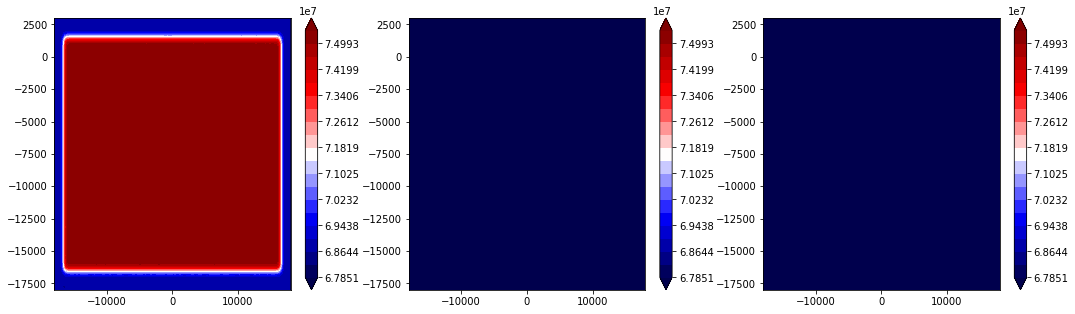

state


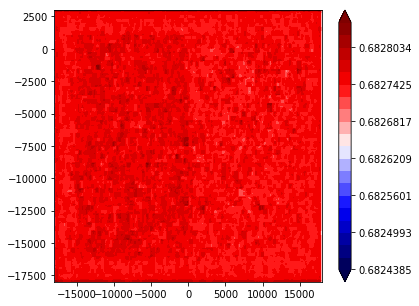

67 1.0814436816
time step vs lapusta 1214415.19298 4637434.471 108419.001249
68 1.11992617688
time step vs lapusta 1214415.19298 4664896.57591 108419.001249
69 1.15840867216
time step vs lapusta 1214415.19298 4611423.84896 108419.001249
slip


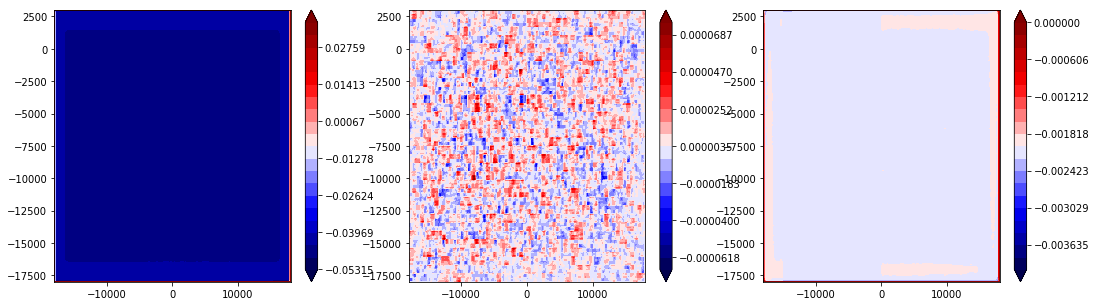

V


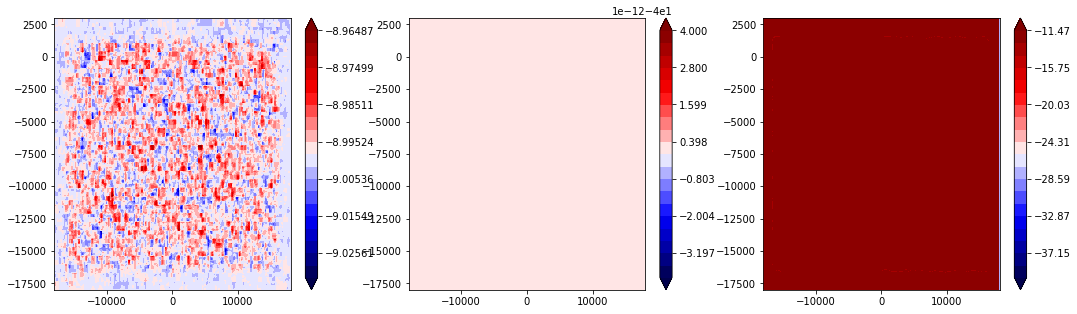

traction


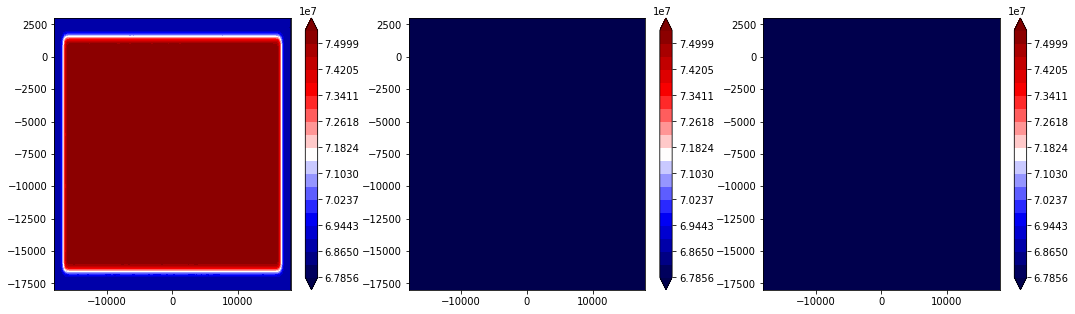

state


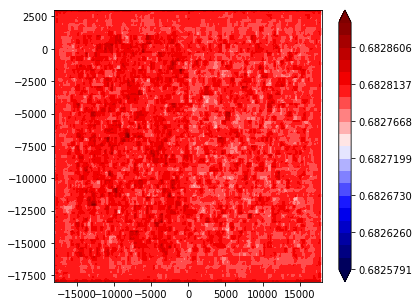

70 1.19689116744
time step vs lapusta 1214415.19298 4587419.02171 108419.001249
71 1.23537366271
time step vs lapusta 1214415.19298 4661784.4126 108419.001249
72 1.27385615799
time step vs lapusta 1214415.19298 4592623.93361 108419.001249
slip


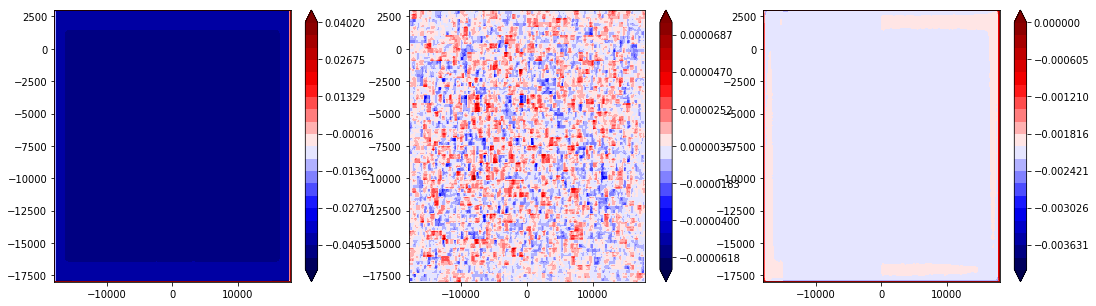

V


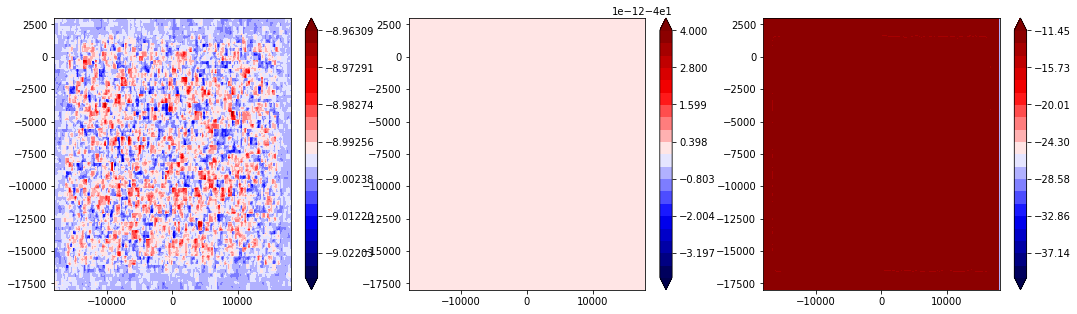

traction


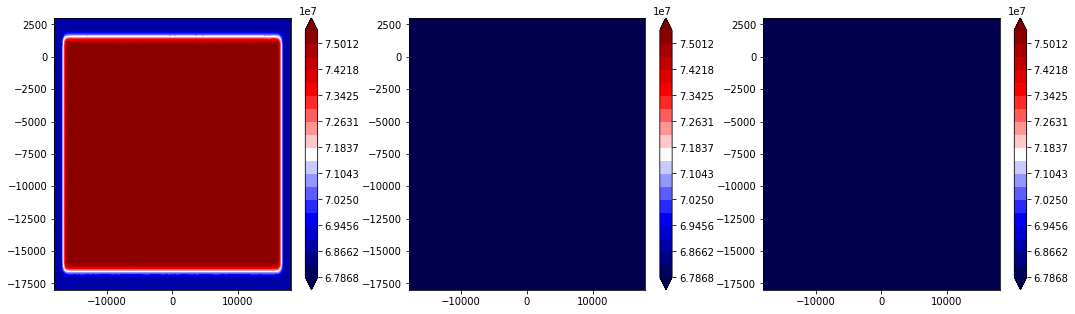

state


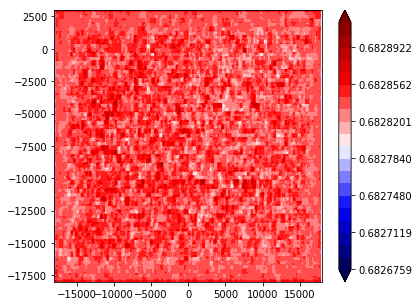

73 1.31233865327
time step vs lapusta 1214415.19298 4657585.32924 108419.001249
74 1.35082114855
time step vs lapusta 1214415.19298 4628327.03094 108419.001249
75 1.38930364383
time step vs lapusta 1214415.19298 4645479.10081 108419.001249
slip


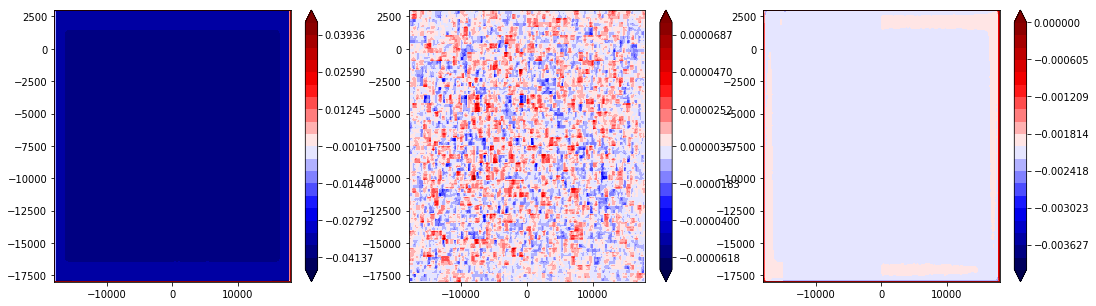

V


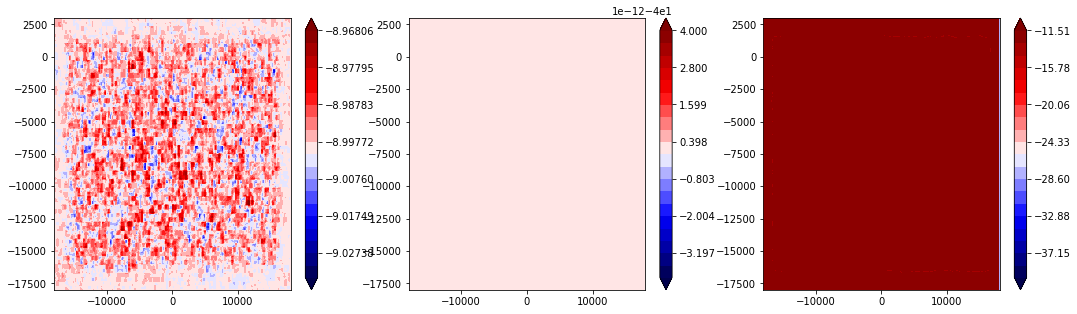

traction


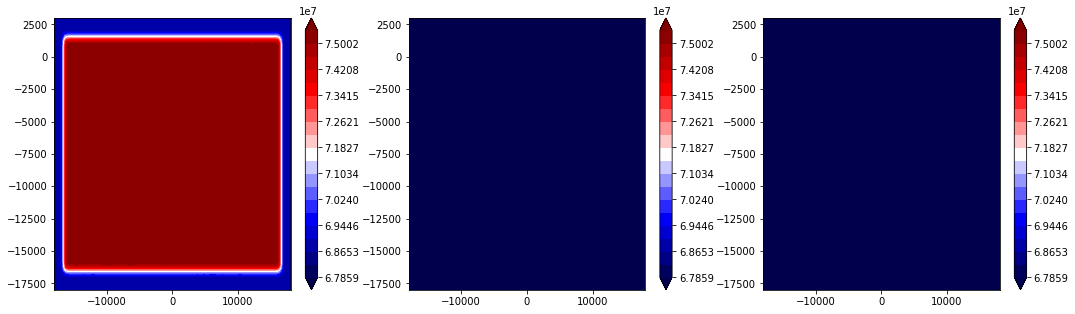

state


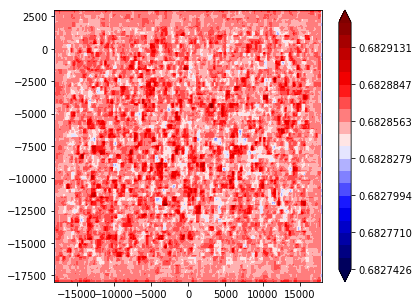

76 1.4277861391
time step vs lapusta 1214415.19298 4533601.97969 108419.001249
77 1.46626863438
time step vs lapusta 1214415.19298 4638597.97926 108419.001249
78 1.50475112966
time step vs lapusta 1214415.19298 4632655.99283 108419.001249
slip


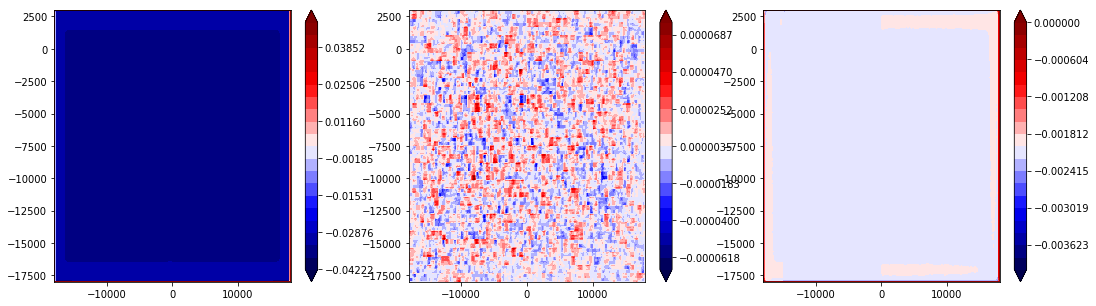

V


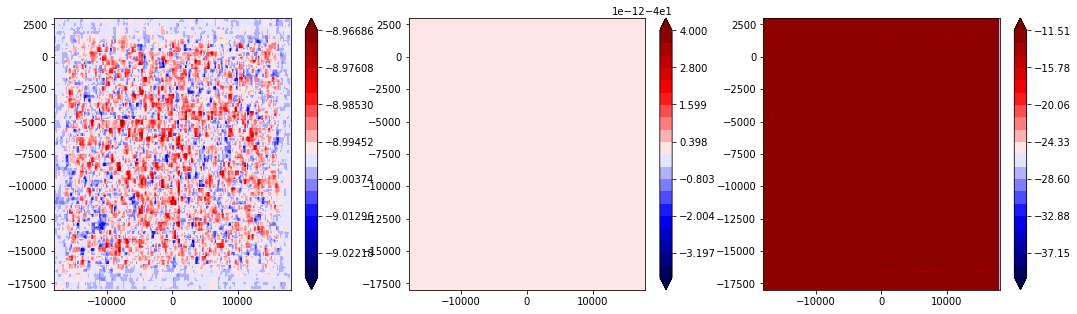

traction


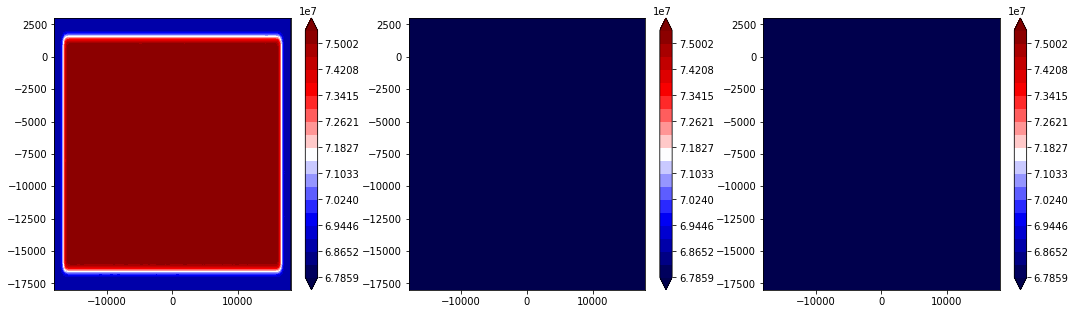

state


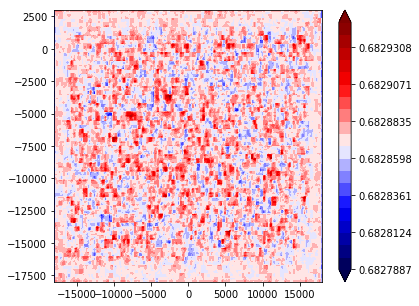

79 1.54323362494
time step vs lapusta 1214415.19298 4503351.47801 108419.001249
80 1.58171612022
time step vs lapusta 1214415.19298 4462632.46668 108419.001249
81 1.62019861549
time step vs lapusta 1214415.19298 4636784.87786 108419.001249
slip


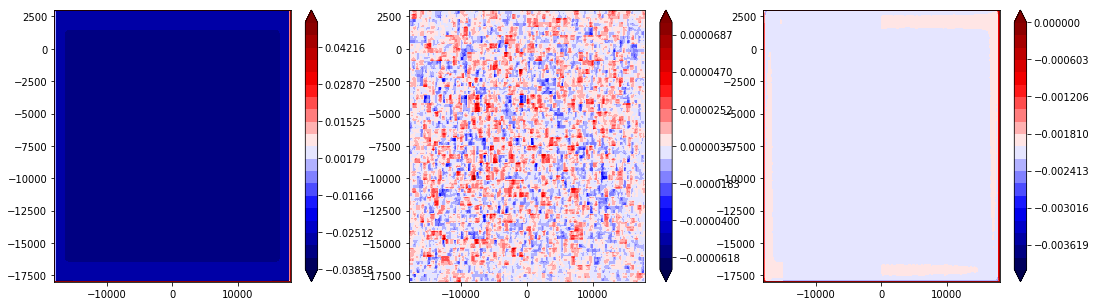

V


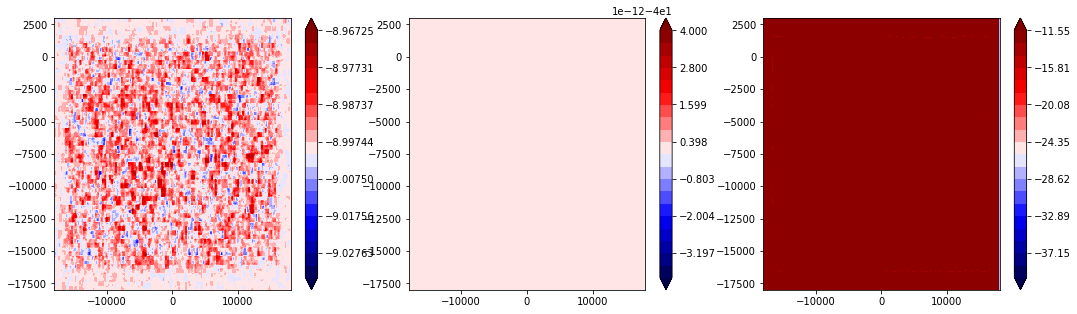

traction


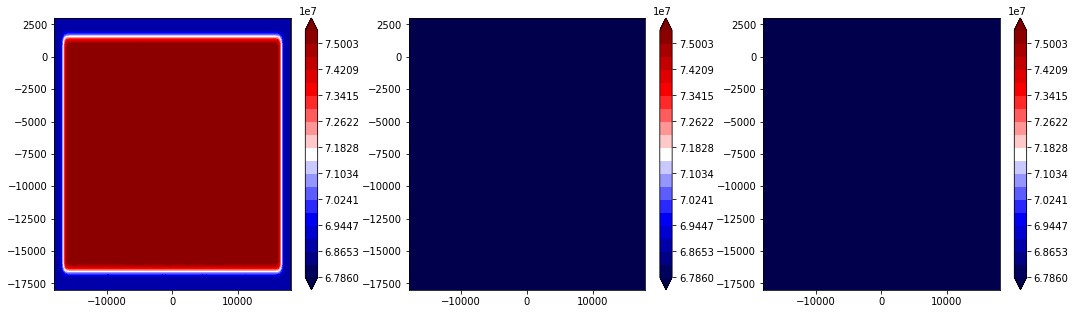

state


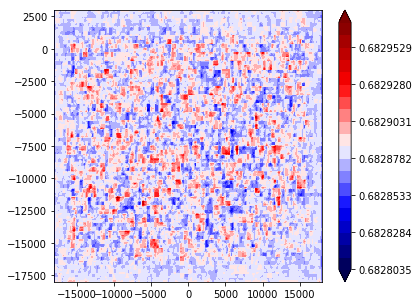

82 1.65868111077
time step vs lapusta 1214415.19298 4615260.02731 108419.001249
83 1.69716360605
time step vs lapusta 1214415.19298 4595016.87361 108419.001249
84 1.73564610133
time step vs lapusta 1214415.19298 4643906.07719 108419.001249
slip


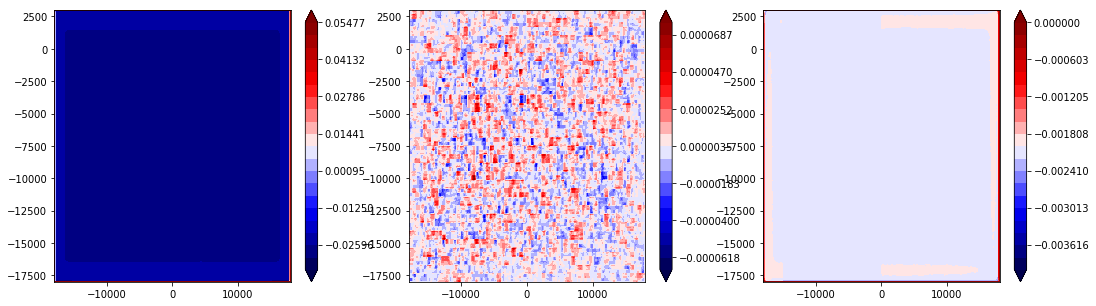

V


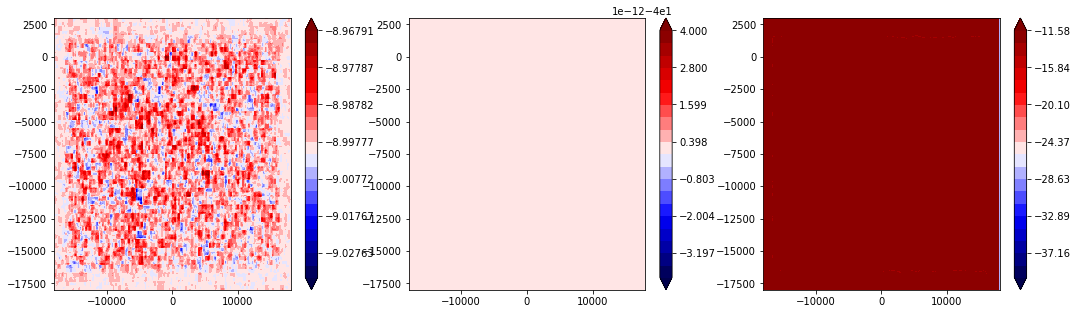

traction


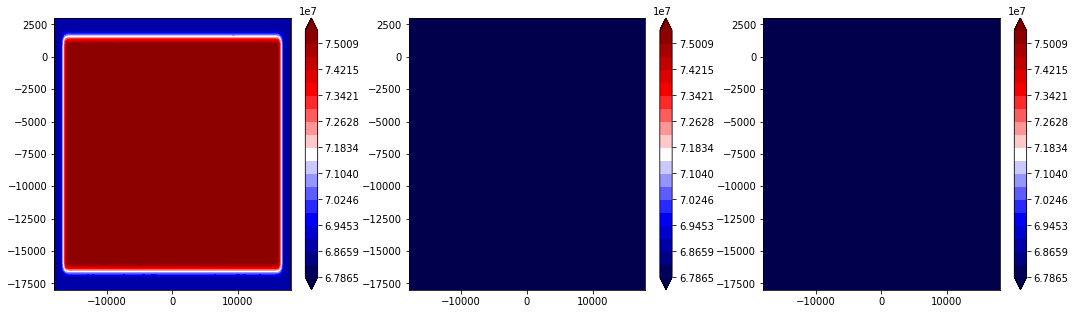

state


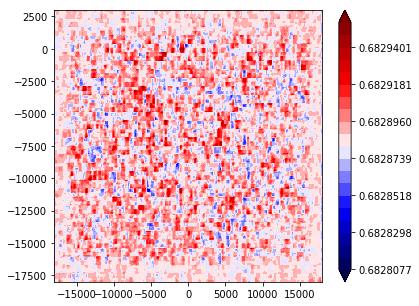

85 1.77412859661
time step vs lapusta 1214415.19298 4607089.59109 108419.001249
86 1.81261109188
time step vs lapusta 1214415.19298 4623379.63678 108419.001249
87 1.85109358716
time step vs lapusta 1214415.19298 4654214.11233 108419.001249
slip


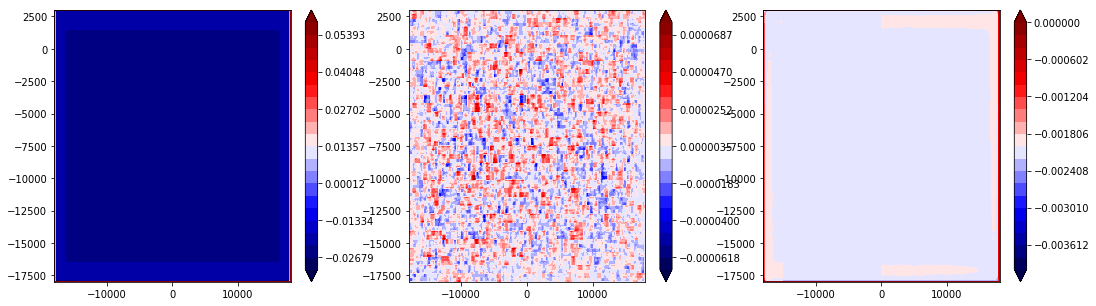

V


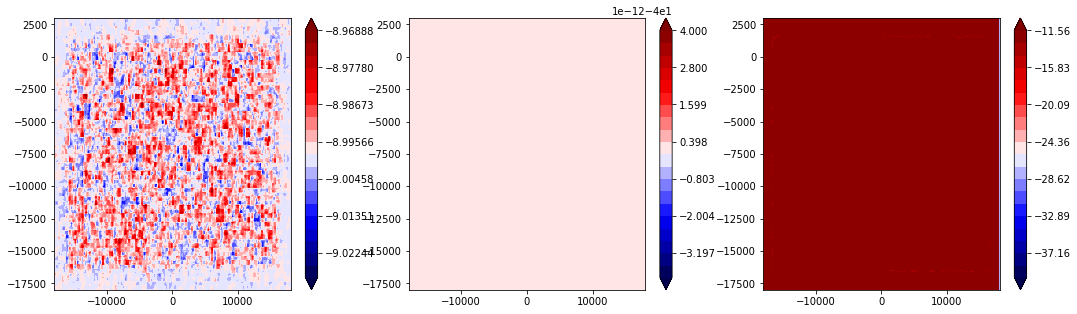

traction


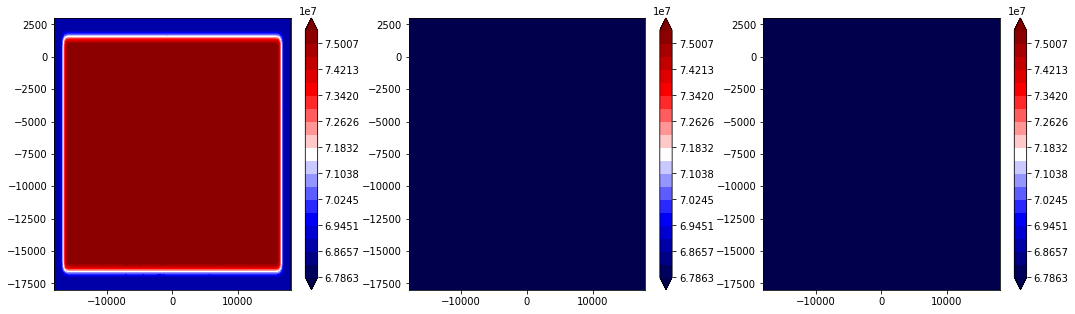

state


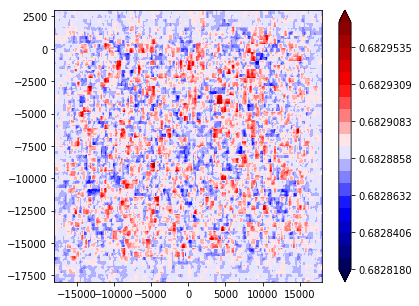

88 1.88957608244
time step vs lapusta 1214415.19298 4623284.68279 108419.001249
89 1.92805857772
time step vs lapusta 1214415.19298 4588861.10202 108419.001249
90 1.96654107299
time step vs lapusta 1214415.19298 4657863.74885 108419.001249
slip


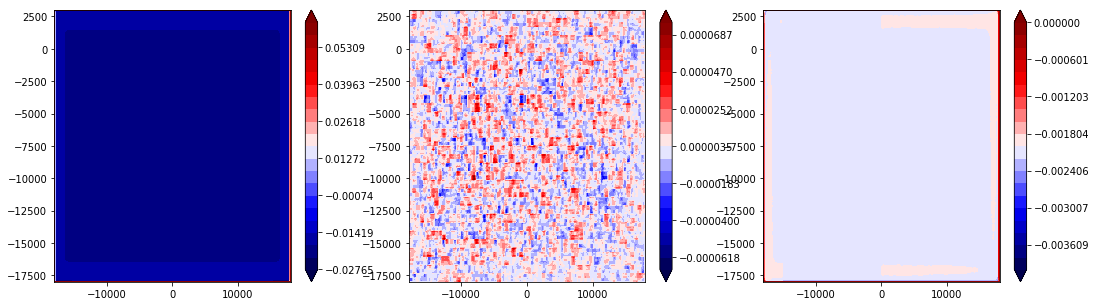

V


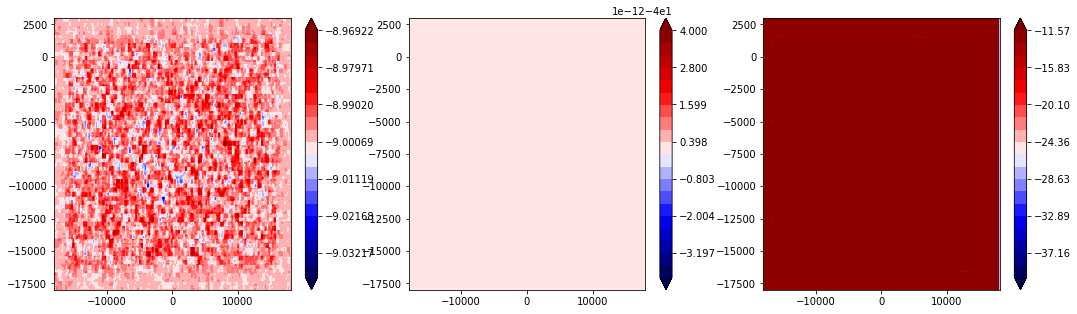

traction


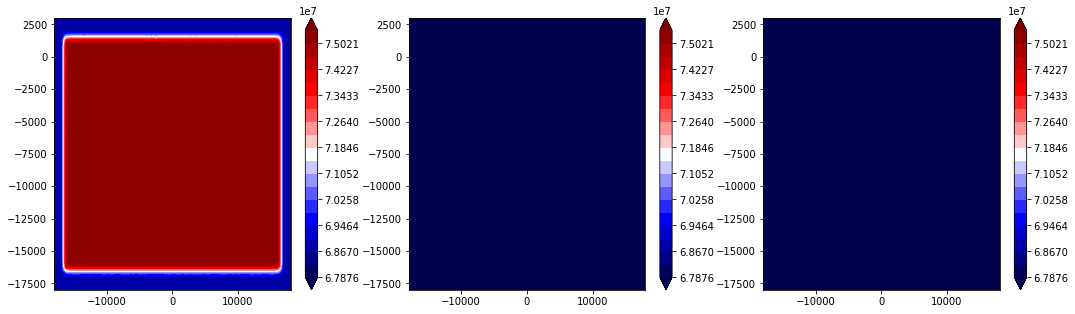

state


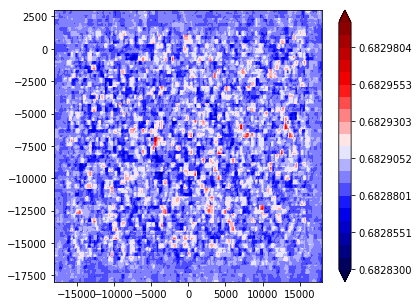

91 2.00502356827
time step vs lapusta 1214415.19298 4607957.75331 108419.001249
92 2.04350606355
time step vs lapusta 1214415.19298 4615185.38943 108419.001249
93 2.08198855883
time step vs lapusta 1214415.19298 4602105.72898 108419.001249
slip


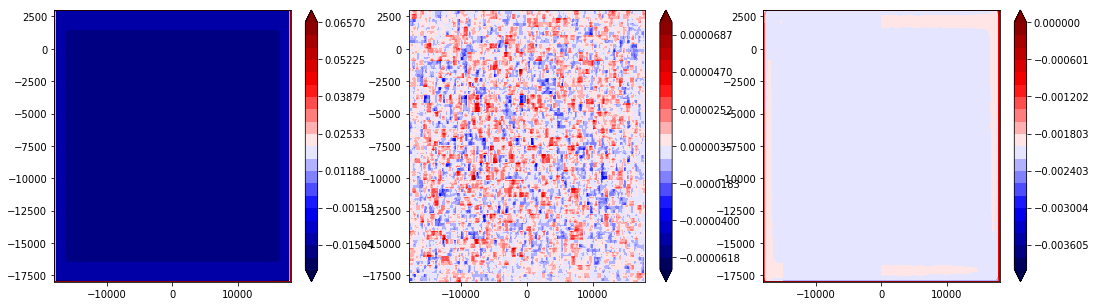

V


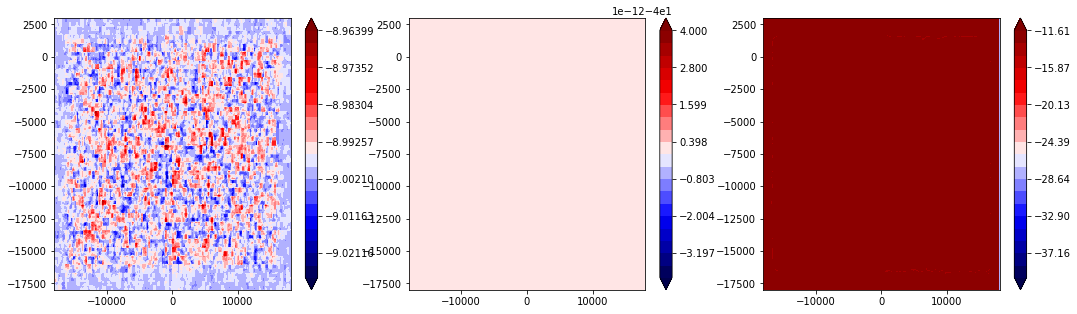

traction


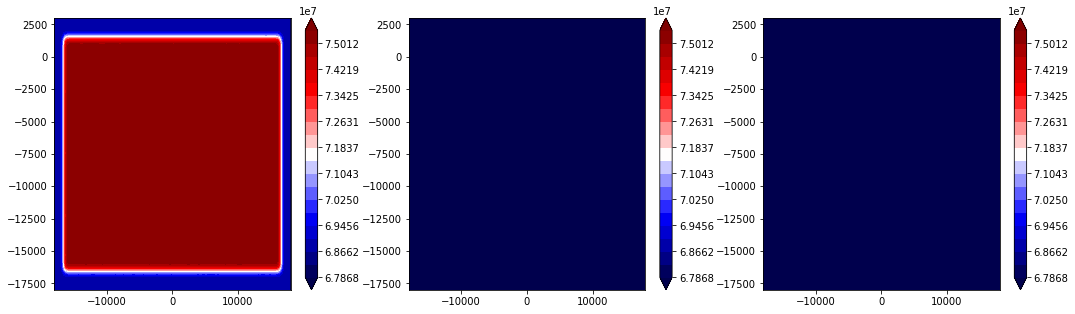

state


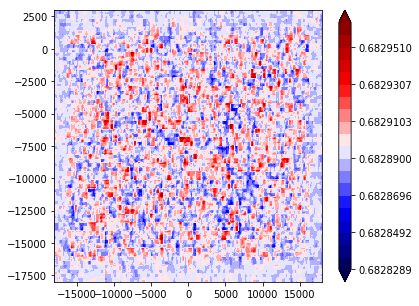

94 2.12047105411
time step vs lapusta 1214415.19298 4573979.29262 108419.001249
95 2.15895354938
time step vs lapusta 1214415.19298 4632724.56351 108419.001249
96 2.19743604466
time step vs lapusta 1214415.19298 4658343.50782 108419.001249
slip


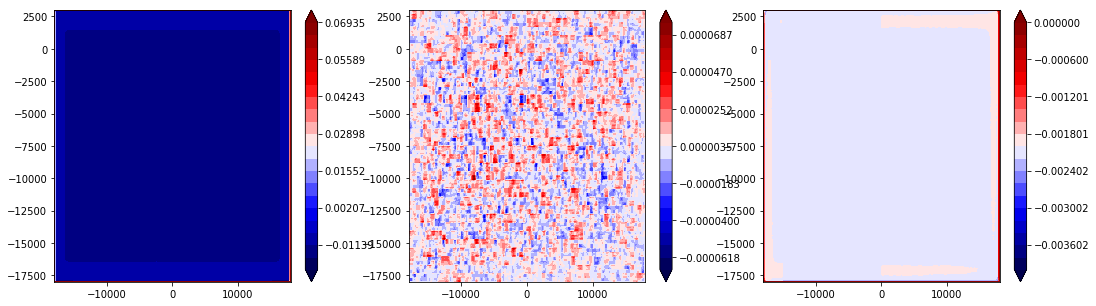

V


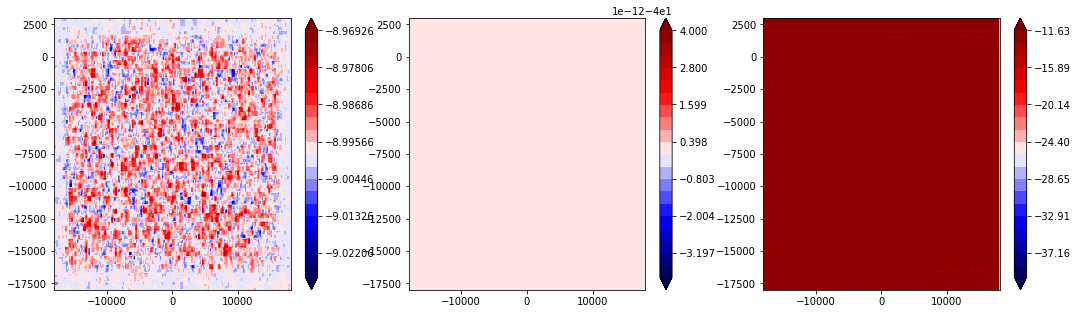

traction


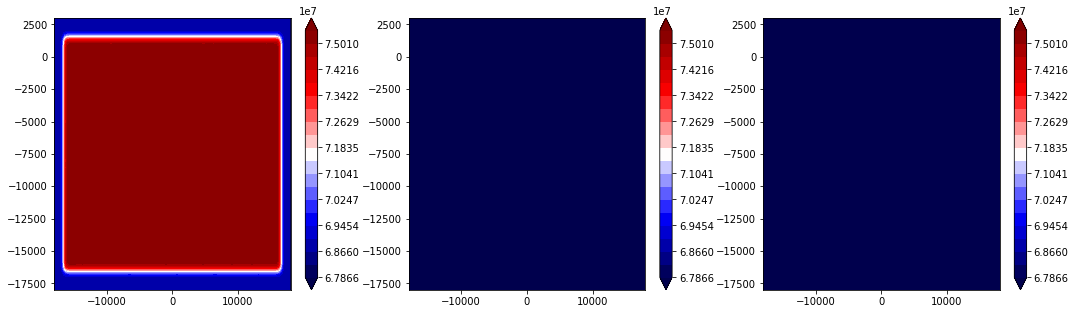

state


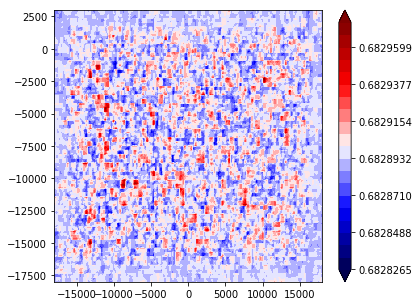

97 2.23591853994
time step vs lapusta 1214415.19298 4634199.74683 108419.001249


In [ ]:
from tectosaur.util.timer import Timer
h_t = []
h_y = []
siay = 60 * 60 * 24 * 365.25
for i in range(150):
    assert(integrator.step() == None)
    h_t.append(integrator.t)
    h_y.append(integrator.y.copy())
    print(i, integrator.t / siay)
    if len(h_t) > 1:
        dt = h_t[-1] - h_t[-2]
        dx = fL / n_fault
        dt_dynamic = mesh_L / qd_cfg['cs'] / 3.0
        dt_evol = 0.5 * qd_cfg['Dc'] / qdm.max_V
        print('time step vs lapusta', dt, dt_evol, dt_dynamic)
    if i % 3 == 0:
        plot_setting(integrator.t, integrator.y, qdm, qd_cfg, slip_to_traction)
    if i % 200 == 0:
        np.save('results.npy', np.array([qdm.m, qd_cfg, h_t, h_y], dtype = np.object))

In [ ]:
t = integrator.t
slip, state = separate_slip_state(integrator.y)
# slip[:] = qdm.slip100_edges
# t = 1.0 * siay
plate_motion = get_plate_motion(qdm, qd_cfg, t)
slip_deficit = get_slip_deficit(qdm, qd_cfg, t, slip)
traction = slip_to_traction(slip_deficit)
V = rate_state_solve(qdm, qd_cfg, traction, state)
dstatedt = state_evolution(qd_cfg, V, state)

In [ ]:
plot_fields(qdm.m, slip)

In [ ]:
V_mag = np.linalg.norm(V.reshape(-1,3), axis = 1)
ss = qd_cfg['f0'] - qd_cfg['b'] * np.log(V_mag / qd_cfg['V0'])
plot_fields(qdm.m, ss)
plot_fields(qdm.m, state)

In [ ]:
plot_fields(qdm.m, slip_deficit)
plot_fields(qdm.m, V)
plot_fields(qdm.m, traction)

In [ ]:
plot_fields(qdm.m, traction, levels = 6 * np.linspace(2.7e7, 3.6e7, 20))